<a href="https://colab.research.google.com/github/AmonAmanyabyona/AI_systems/blob/main/timeseries_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTE: Worked on this project with Chiara Campitiello and Marco Schiavo**

# Hardware and Software for Big Data
## Time Series Analysis: Junyi Academy Foundation

In [ ]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from imblearn.over_sampling import RandomOverSampler

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
from keras.callbacks import Callback


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from scipy.signal import correlate

import warnings
warnings.filterwarnings('ignore')
print("All libraries imported successfully!")

All libraries imported successfully!


Junyi Academy Foundation, a non-profit organization based in Taiwan that aims to provide all children equitable quality
education by technology, is eager to support our learning community during this pandemic. We release a dataset consisting
of over 16 million exercise attempt logs on our platform from more than 72,000 students over the course of a year
(from 2018/08 to 2019/07). We hope our dataset could empower the research of creating a better and personalized learning
experience for students, and further encourage broader participation for contributing to the future of online learning
from interdisciplinary experts.

## Data Description

We provide three tables in the dataset.

- __Log_Problem.csv__ recorded 16,217,311 problem attempts of 72,630 selected students for a year from 2018/08 to 2019/07.

- __Info_Content.csv__ describes the metadata of the exercises, each exercise is a basic unit of learning consisted of many problems.

- __Info_UserData.csv__ describes the metadata of the selected registered students in Junyi Academy.

In [ ]:
df = pd.read_csv('Log_Problem.csv')
#df2 = pd.read_csv('Info_UserData.csv')
#df3 = pd.read_csv('Info_Content.csv')

In [ ]:
#print(df.head())

print('Log_Problem info')
print('\n')
print(df.info())

Log_Problem info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16217311 entries, 0 to 16217310
Data columns (total 14 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   timestamp_TW                     object
 1   uuid                             object
 2   ucid                             object
 3   upid                             object
 4   problem_number                   int64 
 5   exercise_problem_repeat_session  int64 
 6   is_correct                       bool  
 7   total_sec_taken                  int64 
 8   total_attempt_cnt                int64 
 9   used_hint_cnt                    int64 
 10  is_hint_used                     bool  
 11  is_downgrade                     object
 12  is_upgrade                       object
 13  level                            int64 
dtypes: bool(2), int64(6), object(6)
memory usage: 1.5+ GB
None


# Description of Log_Problem's columns:
- **timestamp_TW**: The timestamp of the first behavior, answered the problem or used a hint. It is in UTC+8 timezone and rounded to the closest 15 mins interval to preserve privacy.
- **uuid**: The unique ID of the user. It can be used to join with Info_UserData.
- **ucid**: The unique ID of the content. It can be used to join with Info_Content.
- **upid**: The unique ID of the problem.
- **problem_number**: The number of problems this user had encountered, including this problem, in this exercise.
- **exercise_problem_repeat_session**: The number of times the user encounters this problem in this exercise.
- **is_correct**: Whether the answer is considered correct or not. Only if the student answered the correct answer for the first time will it be `TRUE`. If the student used a hint or answered the wrong answer for the first time, it will be `FALSE`.
- **total_sec_taken**: How many seconds the user use for this problem encounter.
- **total_attempt_cnt**: How many times have the user submitted an answer for this problem encounter.
- **used_hint_cnt**: How many hints the user have used for this problem encounter.
- **level**: from 0 to 4

### More information about level and upgrade and downgrade
There are **_five possible levels_**, all users start from level 0 and progress to level 4 which we considered Proficient for that exercise.

To reach level 1, the user will have to answer the problems correctly 5 times in the recent 6 problems attempts in the exercise.

After reaching level 1, the user is required to wait 6 hours before he/she is able to attempt to level up again to level 2.

After the waiting, the user will answer 2 problems from the exercise. For example, the user is at level 2 and get a chance to answer 2 problems:

> If both are correct, the user is upgraded to level 3.
> If both are incorrect, the user is downgraded to level 1.
> If one of them is correct and one of them is incorrect, the level is unchanged and the user is prompted to try again the challenge.

The procedure to upgrade or downgrade is the same for the other levels. But users will not be downgraded at level 1 or when the user reaches level 4 Proficient.

After reaching level 2, the user is required to wait 16 hours before he/she is able to attempt to level up again to level 3.

After reaching level 3, the user is required to wait 40 hours before he/she is able to attempt to level up again to level 4, which is the final level and considered Proficient for that exercise.




In [ ]:
df2.head()

print('Info_UserData info')
print('\n')
print(df2.info())

Info_UserData info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72758 entries, 0 to 72757
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   uuid                  72758 non-null  object
 1   gender                32905 non-null  object
 2   points                72758 non-null  int64 
 3   badges_cnt            72758 non-null  int64 
 4   first_login_date_TW   72758 non-null  object
 5   user_grade            72758 non-null  int64 
 6   user_city             72758 non-null  object
 7   has_teacher_cnt       72758 non-null  int64 
 8   is_self_coach         72758 non-null  bool  
 9   has_student_cnt       72758 non-null  int64 
 10  belongs_to_class_cnt  72758 non-null  int64 
 11  has_class_cnt         72758 non-null  int64 
dtypes: bool(1), int64(7), object(4)
memory usage: 6.2+ MB
None


# Description Info_UserData's columns
- **uuid**: The unique ID of this user
- **gender**: The gender of this user. There are four possible values: `male`, `female`, `unspecified` and `null`.
- **points**: The user will receive energy points from the Junyi Academy after completing exercises, watching videos, and when the user receives a badge.
- **badges_cnt**: Badges are awarded to the users when the user achieves certain conditions.
- **first_login_date_TW**: The first login date after the user registers to Junyi Academy.
- **user_grade**: The grade of the user. The possible values are between 1 and 12.
- **user_city**: The resident city of the user.
- **has_teacher_cnt**: The number of teachers this user has in the Junyi Academy.
- **is_self_coach**: Does the user add himself/herself as a teacher of their own?
- **has_student_cnt**: The number of students this user has in the Junyi Academy. Despite the user role of this user is a student, this user can still add another user as a student.



### More information about points, variable of interest

The user will receive energy points from the Junyi Academy after completing exercises,
watching videos, and Energy Points are earned from Junyi Academy after completing exercises, watching videos, and when the user receives a badge.

A user earns 750 * (effective watching time / video length) _energy points after watching a video_.
(Effective watching time for a 10-minute video at 2X speed will be only 5-minute)

A user earns a base of 75 energy points after *completing an exercise* at level 0.
(Details of the leveling system will be described in the Proficiency Mechanism Section in Log_Problem's description)

This might increase to at most 225 due to fast answering speed or repeated correct attempts.
The points earned will decrease to as few as 5 as the user's level of that exercise increase to encourage the user to practice other exercises.


In [ ]:
df3.head()

print('Info_Content info')
print('\n')
df3.info()

Info_Content info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ucid                 1330 non-null   object
 1   content_pretty_name  1330 non-null   object
 2   content_kind         1330 non-null   object
 3   difficulty           1330 non-null   object
 4   subject              1330 non-null   object
 5   learning_stage       1330 non-null   object
 6   level1_id            1330 non-null   object
 7   level2_id            1330 non-null   object
 8   level3_id            1330 non-null   object
 9   level4_id            1330 non-null   object
dtypes: object(10)
memory usage: 104.0+ KB


# Description Info_Content's columns
- **ucid**: The hashed unique ID of the content.
- **content_pretty_name**: The Chinese display name of this content.
- **content_kind**: The kind of this content. The current dataset release only includes `Exercise`.
- **difficulty**: The difficulty of this content. There are four possible values: `Easy`, `Normal`, `Hard` and `Unset`. Unset means that this content has not been set to any difficulty yet.
- **subject**: The subject of this content. The current dataset release only includes `math`.
- **learning_stage**: The learning stage of this content. There are three possible values: `Elementary`, `Junior` and `Senior`.
- **level1_id**: The hashed level 1 layer ID of this content.
- **level2_id**: The hashed level 2 layer ID of this content.
- **level3_id**: The hashed level 3 layer ID of this content.
- **level4_id**: The hashed level 4 layer ID of this content.


<img src="photo.jpg" alt="Subject per level" width="500" height="400">


## Missing Values

In [ ]:
print('Missing values of Log_Problem')
print('------------------')
print(df.isna().sum())
print('\n')
print('Missing Values of Info_UserData')
print('------------------')

print(df2.isna().sum())
print('\n')

print('Missing Values of Info_Content')
print('------------------')

print(df3.isna().sum())

Missing values of Log_Problem
------------------
timestamp_TW                              0
uuid                                      0
ucid                                      0
upid                                      0
problem_number                            0
exercise_problem_repeat_session           0
is_correct                                0
total_sec_taken                           0
total_attempt_cnt                         0
used_hint_cnt                             0
is_hint_used                              0
is_downgrade                       14436018
is_upgrade                         14436018
level                                     0
dtype: int64


Missing Values of Info_UserData
------------------
uuid                        0
gender                  39853
points                      0
badges_cnt                  0
first_login_date_TW         0
user_grade                  0
user_city                   0
has_teacher_cnt             0
is_self_coach               0

### Handling missing values
- Imputation, for example filling taking the value of the previous or next timestamp, interpolation...
- Deletion of time points with missing data

In our case, we could fill the missing values based on the previous or next values. However, there are variables where this approach is not appropriate (e.g., a user's gender does not depend on the gender of the next user).
We can also delete the rows, but we are not interesting in these 3 variables, so we do not include them for computing the models.

## Exploratory Data Analysis (EDA)

### Data Transformation

In [ ]:
## Convert the variables from numeric to categorical
df['level'] = df['level'].astype('category')
df2['user_grade'] = df2['user_grade'].astype('category')
df3['learning_stage'] = df3['learning_stage'].astype('category')
df3['difficulty'] = df3['difficulty'].astype('category')

### Data Description

In [ ]:
print('Log_Problem Description')
print('------------------')
print(df.describe())

Log_Problem Description
------------------
       problem_number  exercise_problem_repeat_session  total_sec_taken  \
count    1.621731e+07                     1.621731e+07     1.621731e+07   
mean     1.045406e+01                     1.261218e+00     4.438166e+01   
std      2.015863e+01                     1.173484e+00     1.005375e+02   
min      1.000000e+00                     1.000000e+00     0.000000e+00   
25%      3.000000e+00                     1.000000e+00     1.000000e+01   
50%      6.000000e+00                     1.000000e+00     2.100000e+01   
75%      1.200000e+01                     1.000000e+00     4.500000e+01   
max      1.702000e+03                     1.190000e+02     1.800000e+03   

       total_attempt_cnt  used_hint_cnt         level  
count       1.621731e+07   1.621731e+07  1.621731e+07  
mean        1.874895e+00   5.333163e-01  4.827990e-01  
std         3.547947e+00   1.156917e+00  9.370259e-01  
min         0.000000e+00   0.000000e+00  0.000000e+00  
2

In [ ]:
print('Info_UserData Description')
print('------------------')
print(df2.describe())

Info_UserData Description
------------------
             points    badges_cnt    user_grade  has_teacher_cnt  \
count  7.275800e+04  72758.000000  72758.000000     72758.000000   
mean   6.304759e+04      9.543789      5.620715         0.884810   
std    1.242042e+05     19.036328      2.041178         1.552795   
min    1.000000e+00      0.000000      1.000000         0.000000   
25%    6.285000e+03      0.000000      4.000000         0.000000   
50%    2.040000e+04      3.000000      6.000000         1.000000   
75%    6.531375e+04     10.000000      7.000000         1.000000   
max    4.047528e+06    760.000000     12.000000       106.000000   

       has_student_cnt  belongs_to_class_cnt  has_class_cnt  
count     72758.000000          72758.000000   72758.000000  
mean          0.203304              0.873306       0.046442  
std           6.413944              1.961188       0.315060  
min           0.000000              0.000000       0.000000  
25%           0.000000          

In [ ]:
print('Info_UserCotent Description')
print('------------------')
print(df3[['difficulty', 'subject', 'learning_stage']].describe())

Info_UserCotent Description
------------------
       difficulty subject learning_stage
count        1330    1330           1330
unique          4       1              3
top          easy    math     elementary
freq          835    1330            784


### Numerical Variables Distribution

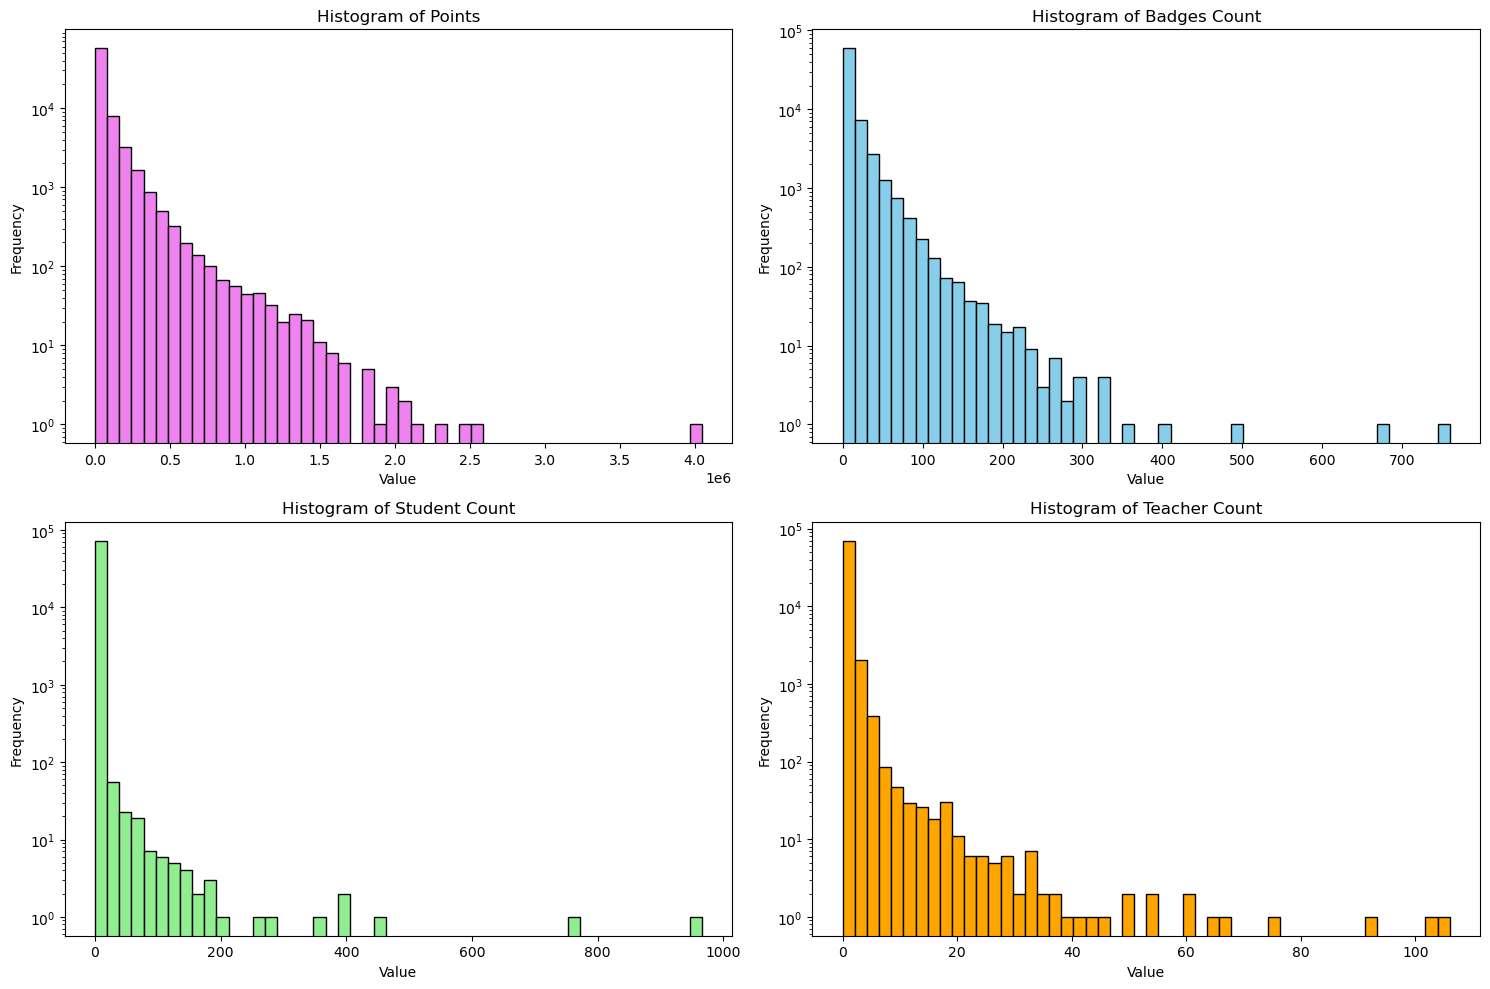

In [ ]:
# Creare la figura e i subplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Istogramma per df2.points
axs[0, 0].hist(df2.points, bins=50, edgecolor='black', color='violet')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Histogram of Points')
axs[0, 0].set_yscale('log')  # Scala logaritmica sull'asse y

# Istogramma per df2.badges_cnt
axs[0, 1].hist(df2.badges_cnt, bins=50, edgecolor='black', color='skyblue')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Histogram of Badges Count')
axs[0, 1].set_yscale('log')  # Scala logaritmica sull'asse y

# Istogramma per df2.has_student_cnt
axs[1, 0].hist(df2.has_student_cnt, bins=50, edgecolor='black', color='lightgreen')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Histogram of Student Count')
axs[1, 0].set_yscale('log')  # Scala logaritmica sull'asse y

# Istogramma per df2.has_teacher_cnt
axs[1, 1].hist(df2.has_teacher_cnt, bins=50, edgecolor='black', color='orange')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Histogram of Teacher Count')
axs[1, 1].set_yscale('log')  # Scala logaritmica sull'asse y

# Aggiustare automaticamente lo spaziamento tra i subplot
plt.tight_layout()

# Mostrare la figura con gli istogrammi
plt.show()


### Categorical Variables Distribution

For check the class of level variable with high frequency, we take only the last value for each student. This because at the beginning everyone are at level '0'.

In [ ]:
df['timestamp_TW'] = pd.to_datetime(df['timestamp_TW'])

df = df.sort_values(by=['timestamp_TW'])

result_last = df.groupby('uuid').last().reset_index()

level_percentages = result_last['level'].value_counts(normalize=True) * 100

print(level_percentages)

level
0    75.841832
1    15.284917
2     4.204349
3     3.005855
4     1.663047
Name: proportion, dtype: float64


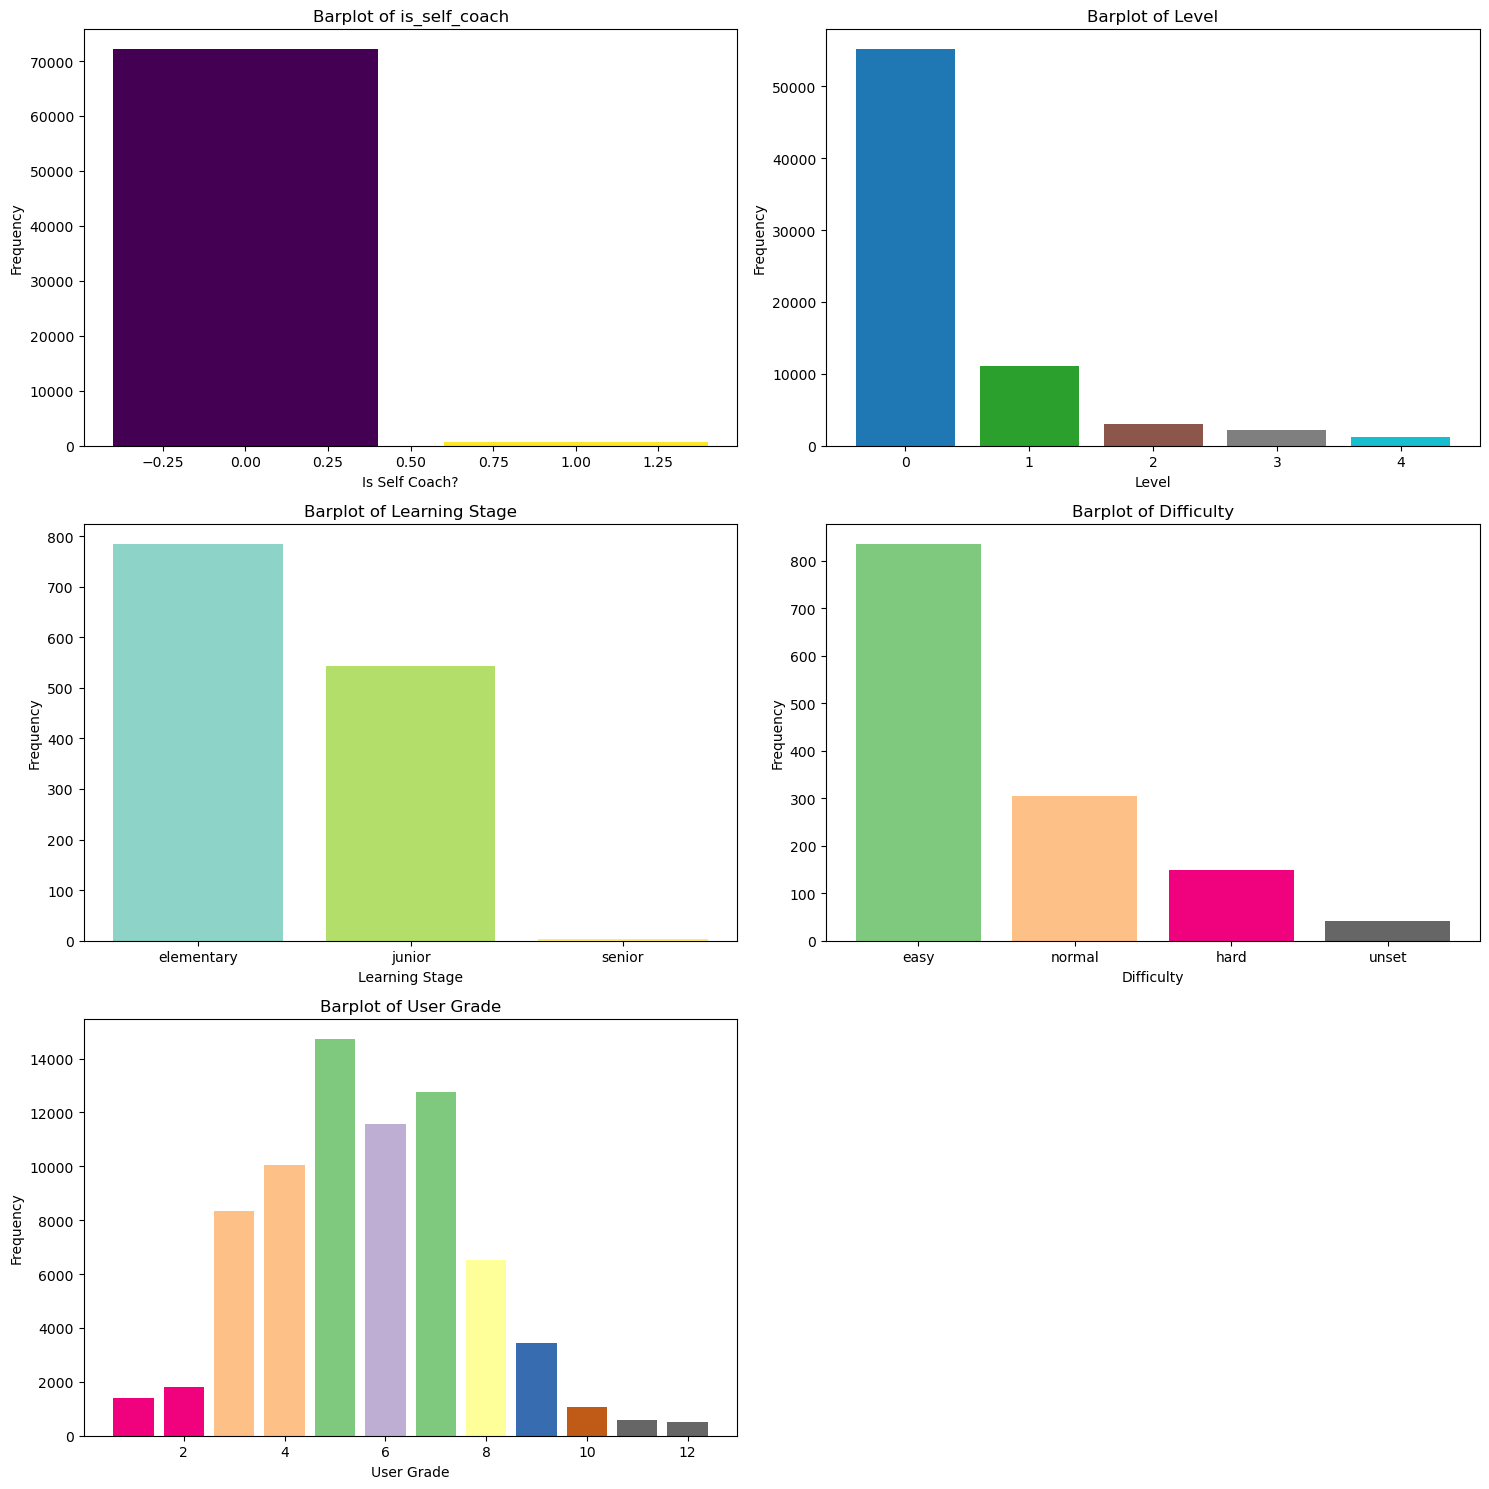

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Barplot for df2.is_self_coach
counts_is_self_coach = df2['is_self_coach'].value_counts()
axs[0, 0].bar(counts_is_self_coach.index, counts_is_self_coach.values, color=plt.cm.viridis(np.linspace(0, 1, len(counts_is_self_coach))))
axs[0, 0].set_xlabel('Is Self Coach?')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Barplot of is_self_coach')

# Barplot for result_last.level
counts_level = result_last['level'].value_counts()
axs[0, 1].bar(counts_level.index, counts_level.values, color=plt.cm.tab10(np.linspace(0, 1, len(counts_level))))
axs[0, 1].set_xlabel('Level')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Barplot of Level')

# Barplot for df3.learning_stage
counts_learning_stage = df3['learning_stage'].value_counts()
axs[1, 0].bar(counts_learning_stage.index, counts_learning_stage.values, color=plt.cm.Set3(np.linspace(0, 1, len(counts_learning_stage))))
axs[1, 0].set_xlabel('Learning Stage')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Barplot of Learning Stage')

# Barplot for df3.difficulty
counts_difficulty = df3['difficulty'].value_counts()
axs[1, 1].bar(counts_difficulty.index, counts_difficulty.values, color=plt.cm.Accent(np.linspace(0, 1, len(counts_difficulty))))
axs[1, 1].set_xlabel('Difficulty')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Barplot of Difficulty')

# Barplot for df2.user_grade
counts_grade = df2['user_grade'].value_counts()
axs[2, 0].bar(counts_grade.index, counts_grade.values, color=plt.cm.Accent(np.linspace(0, 1, len(counts_grade))))
axs[2, 0].set_xlabel('User Grade')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Barplot of User Grade')

fig.delaxes(axs[2, 1])

plt.tight_layout()

plt.show()


In [ ]:
pd.crosstab(df3['difficulty'], df3['learning_stage'], normalize='all') * 100

learning_stage,elementary,junior,senior
difficulty,,,
easy,37.593985,25.037594,0.150376
hard,7.218045,3.984962,0.000000
normal,13.007519,9.924812,0.000000
unset,1.127820,1.879699,0.075188


### Correlation Matrix of numerical variables


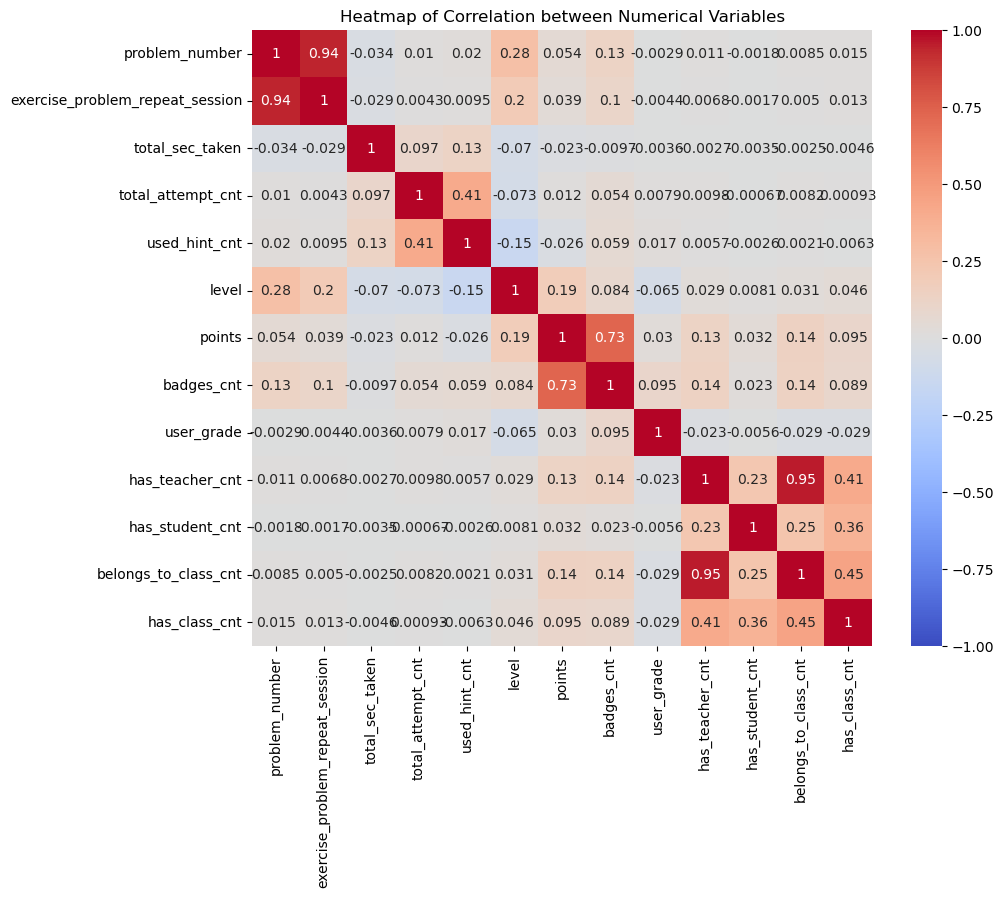

In [ ]:
df_merged = pd.read_csv('df_merged.csv')

df_numerical = df_merged.select_dtypes(include=['float64', 'int64'])

correlation_matrix = df_numerical.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between Numerical Variables')
plt.show()

The correlation matrix, through its coloration and intensity, indicates whether there is a linear relationship between variables. Most of these variables show values close to zero, which signifies a lack of correlation. None of these variables exhibit a strong negative linear correlation. However, certain pairs of variables, such as problem_number and exercise_problem_repeat_session, points and badge_cnt, as well as belong_to_class_cnt and has_teacher_cnt, are strongly positively correlated. This implies that they tend to increase together.

## Classification analysis: Learning Stage

In [ ]:
dff = pd.read_csv('result2.csv')
result_new = pd.read_csv('result_new.csv')

result_finale_modelli = pd.merge(dff, result_new, on='uuid', how='inner')
result_finale_modelli = result_finale_modelli.drop('Unnamed: 0', axis = 1)
result_finale_modelli['learning_stage'] = result_finale_modelli['learning_stage'].astype('category')

result_finale_modelli.head()


,uuid,badges_cnt,points,total_attempt_cnt,used_hint_cnt,total_sec_taken,is_correct,learning_stage,day,Numbers_of_login_for_user,max_days_inactive,unique_activity_days
0,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1,16725,5,0,302,5,1,2018-12-22,11813,221,1
1,++9EkR6syMGk44XpyhOj40cg9xiXwCLS/TwEy+ujrL0=,3,1200,52,29,428,3,1,2019-05-22,11122,294,1
2,++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,0,9533,16,5,898,7,0,2018-09-16,10949,318,1
3,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,0,8027,52,54,1550,23,0,2018-12-02,8926,241,2
4,++GobOSWqrsaxoRg1bMN+T6biIJcgBXwuOH/ddq3DiU=,2,41831,188,7,4943,137,1,2019-06-15,8772,255,3


The dataset `result`, which contains the following variables:

- uuid
- badges_cnt
- points
- total_attempt_cnt
- used_hint_cnt
- total_sec_taken
- is_correct
- learning_stage
- day
- Numbers_of_login_for_user
- max_days_inactive
- unique_activity_days

All variables, except for `max_days_inactive` and `unique_activity_days`, have been obtained using the group by function with various mathematical operators.

The variable `max_days_inactive` represents the maximum inactivity period, calculated by considering the user's logins and identifying the longest period during which they did not log in.
For instance, if a user only logged in on the 22nd of November 2018 and the 2nd of December 2018, the maximum day inactive for that user will be 241 days as the user was inactive till the end of the session which was their maximum duration without any activity



In [ ]:
result_finale_modelli.max_days_inactive.describe()

count    72758.000000
mean       228.856401
std         80.714439
min         18.000000
25%        187.000000
50%        232.000000
75%        294.000000
max        364.000000
Name: max_days_inactive, dtype: float64

## Model
Model creation in machine learning involves several steps, from data collection and preparation to the selection and training of the algorithm. A model is a mathematical implementation of a machine learning hypothesis that seeks to capture the relationship between input features and the output.  

Steps:
- Data Collection: Gathering raw data relevant to the problem.
- Data Preparation: Cleaning and preprocessing the data, including handling missing values and normalizing or scaling features.
- Feature Engineering: Creating new features or transforming existing ones to improve model performance.
- Model Selection: Choosing the appropriate machine learning algorithm.
- Training: Fitting the model to the training data by adjusting parameters to minimize a loss function.
- Evaluation: Assessing model performance using validation data and metrics such as accuracy, precision, recall, etc.
- Deployment: Implementing the model in a production environment for making predictions on new data.

## Parameters   

In the context of machine learning, parameters are the internal configurations of a model that are learned from the training data. They are critical for the model's predictions and are adjusted during the training process to minimize the loss function.  
### Types of Parameters:   
Weights ($ W $):   
Coefficients that are multiplied by the input features. For a linear model, the prediction is given by:  
$$\hat{y} = W \cdot X + b $$
Where $\hat{y}$ is the predict output, $W$ is the weight vector,  $X$ is the input feature vector, and $b$ is the bias term.  
Bias ($ b $): : A parameter added to the weighted sum of inputs to allow the model to fit the data better. It acts as an offset.   

## Softmax

The softmax function is used for classification problem in a NN model, it has to be used as the last layer with a number of nodes equal to the number of different classes that we want to classify.  
The formula is this one:   
$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$
Where $i = 1,..., W$.   




### Properties:

- Probabilites Sum to One: The output of the softmax function is a probability distribution, meaning all values are between 0 and 1, and they sum to 1.
- Exponentiation: The exponential function $e^{(z_j)}$ ensures that the outputs are always positive.
- Normalization: The division by the sum of all exponentials normalizes the outputs to form a probability distribution.



In [ ]:
class ModelDataPreparer:

    def __init__(self, df):
        self.df = df

    def prepare_data(self, y, test_size=0.2, random_state=42):
        colonna_da_eliminare = y
        y = self.df[y]
        x = self.df.drop(colonna_da_eliminare, axis = 1)
        if(colonna_da_eliminare =='learning_stage'):
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify = y)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

        print("modelli preparati in prepare")
        return self.X_train, self.X_test, self.y_train, self.y_test


    def modelNN_classification_relu(self, epochs, y):
        self.prepare_data(y)

        # Stampa del numero di elementi per classe nel train set
        unique, counts = np.unique(self.y_train, return_counts=True)
        train_class_counts = dict(zip(unique, counts))
        print(f'Train class counts: {train_class_counts}')

        # Stampa del numero di elementi per classe nel test set
        unique, counts = np.unique(self.y_test, return_counts=True)
        test_class_counts = dict(zip(unique, counts))
        print(f'Test class counts: {test_class_counts}')

        num_classes = len(np.unique(self.y_train))
        self.y_train_one_hot = to_categorical(self.y_train, num_classes=num_classes)
        self.y_test_one_hot = to_categorical(self.y_test, num_classes=num_classes)

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        self.info_classification_train()


        model = Sequential()
        model.add(Input(shape=(self.X_train.shape[1],)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))  # Output layer con softmax per classificazione multiclasse

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(self.X_train, self.y_train_one_hot, epochs=epochs, batch_size=10, validation_split=0.2)

        self.model = model

        _, accuracy = model.evaluate(self.X_test, self.y_test_one_hot)
        print(f'Accuracy: {accuracy:.2f}')

        y_pred = model.predict(self.X_test)

        new_df = {'self.y_test_one_hot': self.y_test_one_hot, 'y_predict': y_pred}

        return accuracy, new_df


    def modelNN_classification_sigmoid(self, epochs, y):

        self.prepare_data(y)

        # Stampa del numero di elementi per classe nel train set
        unique, counts = np.unique(self.y_train, return_counts=True)
        train_class_counts = dict(zip(unique, counts))
        print(f'Train class counts: {train_class_counts}')

        # Stampa del numero di elementi per classe nel test set
        unique, counts = np.unique(self.y_test, return_counts=True)
        test_class_counts = dict(zip(unique, counts))
        print(f'Test class counts: {test_class_counts}')

        num_classes = len(np.unique(self.y_train))
        self.y_train_one_hot = to_categorical(self.y_train, num_classes=num_classes)
        self.y_test_one_hot = to_categorical(self.y_test, num_classes=num_classes)

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        self.info_classification_train()


        model = Sequential()
        model.add(Input(shape=(self.X_train.shape[1],)))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(num_classes, activation='softmax'))  # Output layer con softmax per classificazione multiclasse

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(self.X_train, self.y_train_one_hot, epochs=epochs, batch_size=10, validation_split=0.2)

        self.model = model

        _, accuracy = model.evaluate(self.X_test, self.y_test_one_hot)
        print(f'Accuracy: {accuracy:.2f}')

        y_pred = model.predict(self.X_test)

        new_df = {'self.y_test_one_hot': self.y_test_one_hot, 'y_predict': y_pred}

        return accuracy, new_df

    def modelNN_classification_relu_oversampling(self, epochs, y):
        self.prepare_data(y)

        # Stampa del numero di elementi per classe nel train set
        unique, counts = np.unique(self.y_train, return_counts=True)
        train_class_counts = dict(zip(unique, counts))
        print(f'Train class counts: {train_class_counts}')

        # Stampa del numero di elementi per classe nel test set
        unique, counts = np.unique(self.y_test, return_counts=True)
        test_class_counts = dict(zip(unique, counts))
        print(f'Test class counts: {test_class_counts}')

        num_classes = len(np.unique(self.y_train))
        self.y_train_one_hot = to_categorical(self.y_train, num_classes=num_classes)
        self.y_test_one_hot = to_categorical(self.y_test, num_classes=num_classes)

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        print("TRAIN BEFORE OVERSAMPLING")
        self.info_classification_train()

        # Applica oversampling e ottiene X_resampled e y_resampled
        X_resampled, y_resampled = self.oversample_minority_classes()

        # Riscrive X_train con X_resampled e y_train con y_resampled
        self.X_train = X_resampled
        self.y_train_one_hot = to_categorical(y_resampled, num_classes=num_classes)

        print("TRAIN AFTER OVERSAMPLING")
        self.info_classification_train()

        model = Sequential()
        model.add(Input(shape=(self.X_train.shape[1],)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))  # Output layer con softmax per classificazione multiclasse

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(self.X_train, self.y_train_one_hot, epochs=epochs, batch_size=10, validation_split=0.2)

        self.model = model

        _, accuracy = model.evaluate(self.X_test, self.y_test_one_hot)
        print(f'Accuracy: {accuracy:.2f}')

        y_pred = model.predict(self.X_test)

        new_df = {'self.y_test_one_hot': self.y_test_one_hot, 'y_predict': y_pred}

        return accuracy, new_df

    def modelNN_classification_sigmoid_oversampling(self, epochs, y):
        self.prepare_data(y)

        # Stampa del numero di elementi per classe nel train set
        unique, counts = np.unique(self.y_train, return_counts=True)
        train_class_counts = dict(zip(unique, counts))
        print(f'Train class counts: {train_class_counts}')

        # Stampa del numero di elementi per classe nel test set
        unique, counts = np.unique(self.y_test, return_counts=True)
        test_class_counts = dict(zip(unique, counts))
        print(f'Test class counts: {test_class_counts}')

        num_classes = len(np.unique(self.y_train))
        self.y_train_one_hot = to_categorical(self.y_train, num_classes=num_classes)
        self.y_test_one_hot = to_categorical(self.y_test, num_classes=num_classes)

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        print("TRAIN BEFORE OVERSAMPLING")
        self.info_classification_train()

        # Applica oversampling e ottiene X_resampled e y_resampled
        X_resampled, y_resampled = self.oversample_minority_classes()

        # Riscrive X_train con X_resampled e y_train con y_resampled
        self.X_train = X_resampled
        self.y_train_one_hot = to_categorical(y_resampled, num_classes=num_classes)

        print("TRAIN AFTER OVERSAMPLING")
        self.info_classification_train()

        model = Sequential()
        model.add(Input(shape=(self.X_train.shape[1],)))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(num_classes, activation='softmax'))  # Output layer con softmax per classificazione multiclasse

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(self.X_train, self.y_train_one_hot, epochs=epochs, batch_size=10, validation_split=0.2)

        self.model = model

        _, accuracy = model.evaluate(self.X_test, self.y_test_one_hot)
        print(f'Accuracy: {accuracy:.2f}')

        y_pred = model.predict(self.X_test)

        new_df = {'self.y_test_one_hot': self.y_test_one_hot, 'y_predict': y_pred}

        return accuracy, new_df

    def evaluate_class_performance(self, new_df):
        y_test_one_hot = new_df['self.y_test_one_hot']
        y_predict = new_df['y_predict']

        # Decodifica one-hot encoding
        y_test_decoded = np.argmax(y_test_one_hot, axis=1)
        y_predict_decoded = np.argmax(y_predict, axis=1)

        classes = np.unique(y_test_decoded)

        # Prepara il DataFrame
        performance_df = pd.DataFrame(index=classes, columns=['Total Elements', 'Correctly Classified', 'Accuracy (%)'])

        for cls in classes:
            # Conta il numero totale di elementi per la classe nel test set
            total_elements = np.sum(y_test_decoded == cls)

            # Conta il numero di elementi correttamente classificati
            correctly_classified = np.sum((y_test_decoded == cls) & (y_predict_decoded == cls))

            # Calcola la percentuale di elementi correttamente classificati
            accuracy = (correctly_classified / total_elements) * 100 if total_elements > 0 else 0

            # Assegna i valori al DataFrame
            performance_df.loc[cls] = [total_elements, correctly_classified, accuracy]

        return performance_df

    def oversample_minority_classes(self):
        X_train = self.X_train
        y_train = self.y_train

        # Applica oversampling al dataset
        ros = RandomOverSampler(random_state=42)
        X_res, y_res = ros.fit_resample(X_train, y_train)

        # Ricrea il DataFrame bilanciato
        X_resampled = pd.DataFrame(X_res)
        y_resampled = pd.Series(y_res, name=self.y_train.name)

        return X_resampled, y_resampled


    def info_classification_train(self):

        y_train_one_hot = self.y_train_one_hot
        # Decodifica one-hot encoding per ottenere le classi originali
        y_train = np.argmax(y_train_one_hot, axis=1)


        print("Learning_stage IN TEST")
        print("learning stage = 0:", np.sum(y_train == 0))
        print("learning stage = 1:", np.sum(y_train == 1))
        print("learning stage = 2:", np.sum(y_train == 2))

        # Conta le occorrenze di ciascuna classe
        class_counts = pd.Series(y_train).value_counts()

        # Calcola la percentuale
        class_percentages = (class_counts / class_counts.sum()) * 100

        # Crea l'istogramma
        class_percentages.plot(kind='bar', color=['blue', 'blue', 'blue'])
        plt.xlabel('Learning Stage')
        plt.ylabel('Percentage')
        plt.title('Percentage of Each Learning Stage IN TRAIN DATASET')
        plt.show()

    def info_classification(self):

        result = self.df

        print("learning stage = 0 :", len(result[result['learning_stage'] ==0]))
        print("learning stage = 1 :",len(result[result['learning_stage'] ==1]))
        print("learning stage = 2 :",len(result[result['learning_stage'] ==2]))

        class_counts = result['learning_stage'].value_counts()

        # Calcola la percentuale
        class_percentages = (class_counts / class_counts.sum()) * 100

        # Crea l'istogramma
        class_percentages.plot(kind='bar')
        plt.xlabel('Learning Stage')
        plt.ylabel('Percentage')
        plt.title('Percentage of Each Learning Stage')
        plt.show()

    def plot_classification_performance(self,performance_df):

        classes = performance_df.index
        accuracy = performance_df['Accuracy (%)'].values
        incorrect = 100 - accuracy  # Calcola la percentuale di elementi classificati erroneamente

        bar_width = 0.35
        index = np.arange(len(classes))

        # Creazione delle barre verdi per la percentuale di elementi correttamente classificati
        plt.bar(index, accuracy, bar_width, color='g', label='Correctly Classified (%)')

        # Creazione delle barre rosse per la percentuale di elementi classificati erroneamente
        plt.bar(index + bar_width, incorrect, bar_width, color='r', label='Incorrectly Classified (%)')

        plt.xlabel('Classes')
        plt.ylabel('Percentage')
        plt.title('Classification Performance by Class')
        plt.xticks(index + bar_width / 2, classes)
        plt.legend()

        plt.show()

    def plot_errors(self, df_err, model_name):
        y_true = df_err['y_test']
        y_pred = df_err['y_predict']

        # Calcola le metriche di errore
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Plot degli errori
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
        plt.title(f"True vs Predicted Values ({model_name})")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot della distribuzione degli errori
        error = y_true - y_pred
        plt.figure(figsize=(10, 6))
        sns.histplot(error, kde=True, color='blue')
        plt.title(f"Distribution of Errors ({model_name})")
        plt.xlabel("Error")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Stampa delle metriche di errore
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R^2 Score: {r2:.2f}")

['learning_stage', 'unique_activity_days', 'max_days_inactive', 'Numbers_of_login_for_user', 'points', 'used_hint_cnt']
learning stage = 0 : 45173
learning stage = 1 : 25780
learning stage = 2 : 1805


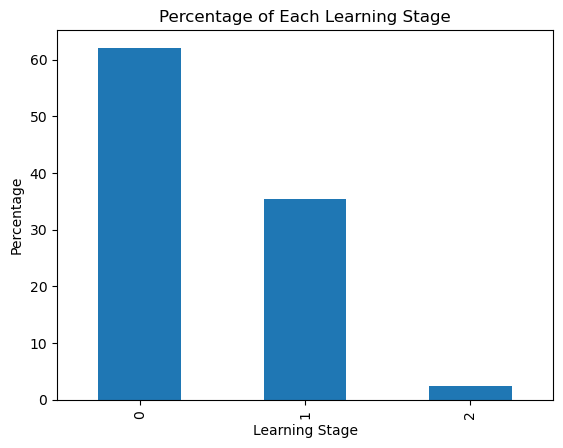

In [ ]:
'''
Index(['uuid', 'badges_cnt', 'points', 'total_attempt_cnt',
       'used_hint_cnt', 'total_sec_taken', 'is_correct', 'learning_stage',
       'day', 'Numbers_of_login_for_user', 'max_giorno_inattivo',
       'max_days_inactive', 'unique_activity_days'],
      dtype='object')
'''
best_variables = ['learning_stage', 'unique_activity_days', 'max_days_inactive','Numbers_of_login_for_user','points','used_hint_cnt']
result = result_finale_modelli[best_variables]
print(best_variables)

MODEL = ModelDataPreparer(result)
MODEL.info_classification()

### Model 1 - RELU
$$
f(x) =
\begin{cases}
x & \text{if } x \geq 0 \\
0 & \text{if } x < 0
\end{cases}
$$

### Model 2 - Sigmoid
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

modelli preparati in prepare
Train class counts: {0: 36138, 1: 20624, 2: 1444}
Test class counts: {0: 9035, 1: 5156, 2: 361}
Learning_stage IN TEST
learning stage = 0: 36138
learning stage = 1: 20624
learning stage = 2: 1444


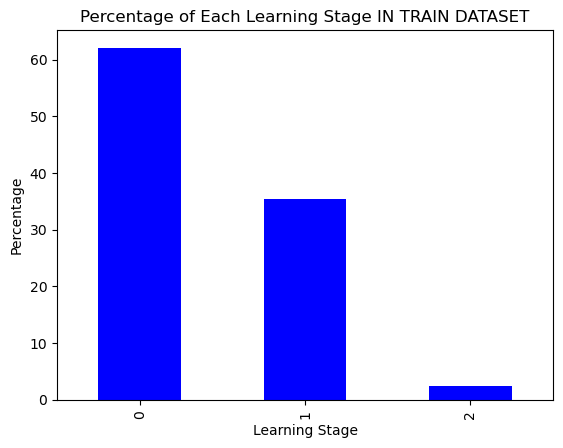

4657/4657 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6222 - loss: 0.7503 - val_accuracy: 0.6316 - val_loss: 0.7306
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6349 - loss: 0.7232
Accuracy: 0.63
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


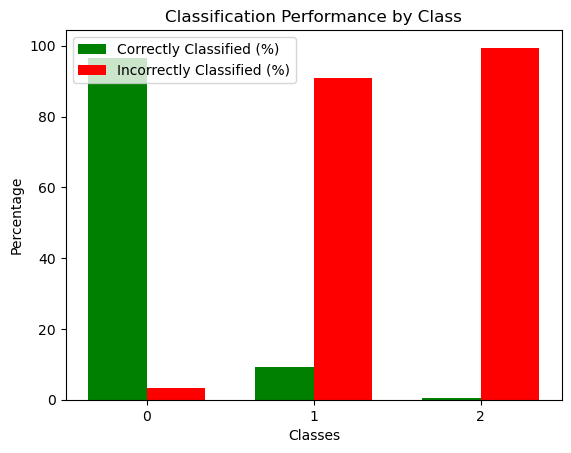

  Total Elements Correctly Classified Accuracy (%)
0           9035                 8724    96.557831
1           5156                  473     9.173778
2            361                    2     0.554017
modelli preparati in prepare
Train class counts: {0: 36138, 1: 20624, 2: 1444}
Test class counts: {0: 9035, 1: 5156, 2: 361}
Learning_stage IN TEST
learning stage = 0: 36138
learning stage = 1: 20624
learning stage = 2: 1444


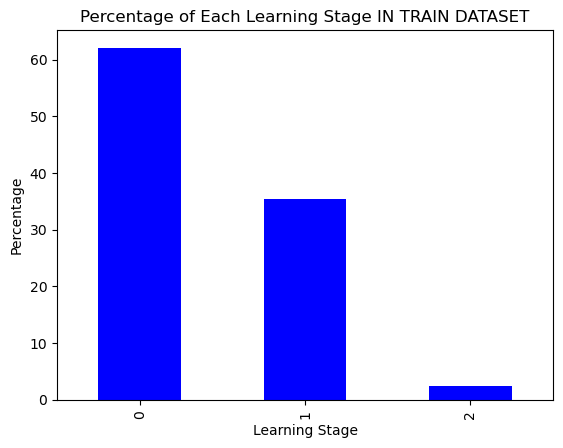

4657/4657 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6093 - loss: 0.7793 - val_accuracy: 0.6259 - val_loss: 0.7369
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6273 - loss: 0.7307
Accuracy: 0.62
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


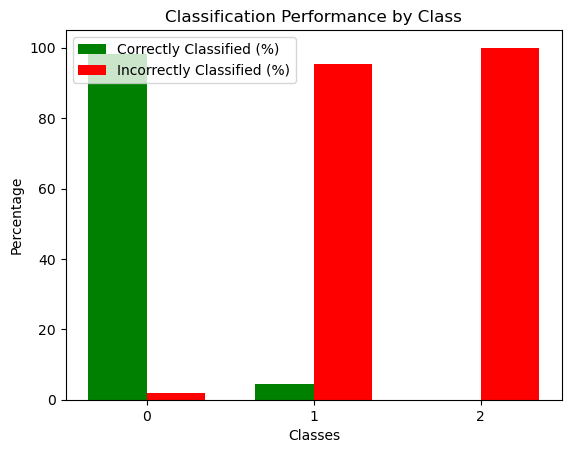

  Total Elements Correctly Classified Accuracy (%)
0           9035                 8862    98.085224
1           5156                  232     4.499612
2            361                    0          0.0


In [ ]:
# MODEL 1
MODEL = ModelDataPreparer(result)
acc,dizio_info = MODEL.modelNN_classification_relu(1,'learning_stage')
df_info = MODEL.evaluate_class_performance(dizio_info)
MODEL.plot_classification_performance(df_info)
print(df_info)

#MODEL 2
MODEL = ModelDataPreparer(result)
acc,dizio_info = MODEL.modelNN_classification_sigmoid(1,'learning_stage')
df_info = MODEL.evaluate_class_performance(dizio_info)
MODEL.plot_classification_performance(df_info)
print(df_info)


### Oversampling

We see that 60-65% is a fake estimation, the model is just wronlgy predicting always class 0 because is unbalanced.

Oversampling is a technique used to address the problem of class imbalance in datasets. When dealing with classification data, it often happens that one or more classes are significantly underrepresented compared to others. This imbalance can lead to machine learning models that do not generalize well, as they may become biased towards the majority class.

One common method of oversampling is the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE works by creating synthetic samples of the minority class, rather than simply duplicating existing ones. Here’s how SMOTE works in a step-by-step manner:

1. **Select a Minority Class Sample**: Randomly select a sample from the minority class.

2. **Find the k-Nearest Neighbors**: Identify the k-nearest neighbors for this sample within the minority class using a distance metric like Euclidean distance.

3. **Generate Synthetic Samples**: For each selected sample, create synthetic samples along the line segments joining the selected sample and its k-nearest neighbors. The new synthetic samples are generated using the formula:
   
   $$\text{synthetic sample} = \text{original sample} + \text{random fraction} \times (\text{neighbor sample} - \text{original sample})$$

   where the random fraction is a number between 0 and 1.

Here is a more formal description of the process:

1. Let $x_i$ be a sample from the minority class.
2. Identify its k-nearest neighbors $ \{ x_{i1}, x_{i2}, \ldots, x_{ik} \} $.
3. For each neighbor $x_{ij}$, generate a new sample $x_{\text{new}}$ as follows:

   $$
   x_{\text{new}} = x_i + \delta \times (x_{ij} - x_i)
   $$

   where $\delta\$ is a random number between 0 and 1.

By adding synthetic samples, SMOTE helps to balance the class distribution and enables the machine learning model to learn the decision boundaries more effectively.

modelli preparati in prepare
Train class counts: {0: 36138, 1: 20624, 2: 1444}
Test class counts: {0: 9035, 1: 5156, 2: 361}
TRAIN BEFORE OVERSAMPLING
Learning_stage IN TEST
learning stage = 0: 36138
learning stage = 1: 20624
learning stage = 2: 1444


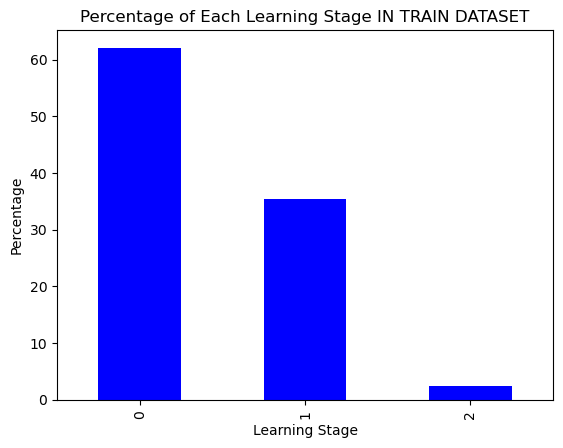

TRAIN AFTER OVERSAMPLING
Learning_stage IN TEST
learning stage = 0: 36138
learning stage = 1: 36138
learning stage = 2: 36138


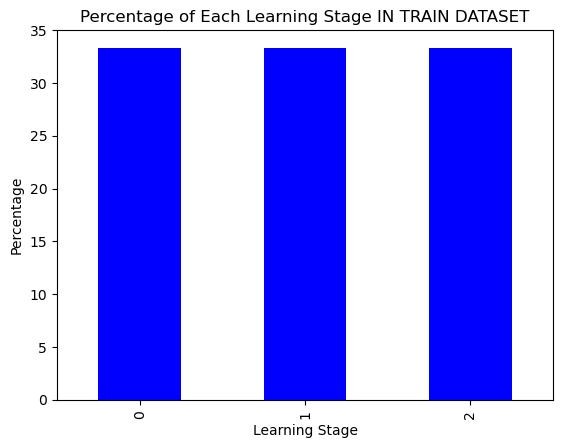

8674/8674 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.4887 - loss: 0.9572 - val_accuracy: 0.4127 - val_loss: 1.4265
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5111 - loss: 0.8612
Accuracy: 0.51
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


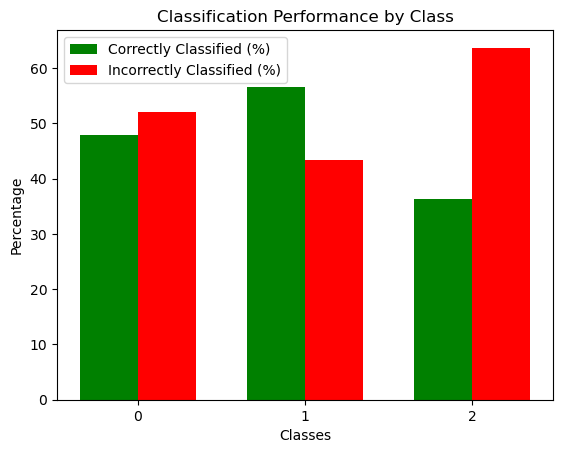

  Total Elements Correctly Classified Accuracy (%)
0           9035                 4327    47.891533
1           5156                 2918    56.594259
2            361                  131    36.288089
modelli preparati in prepare
Train class counts: {0: 36138, 1: 20624, 2: 1444}
Test class counts: {0: 9035, 1: 5156, 2: 361}
TRAIN BEFORE OVERSAMPLING
Learning_stage IN TEST
learning stage = 0: 36138
learning stage = 1: 20624
learning stage = 2: 1444


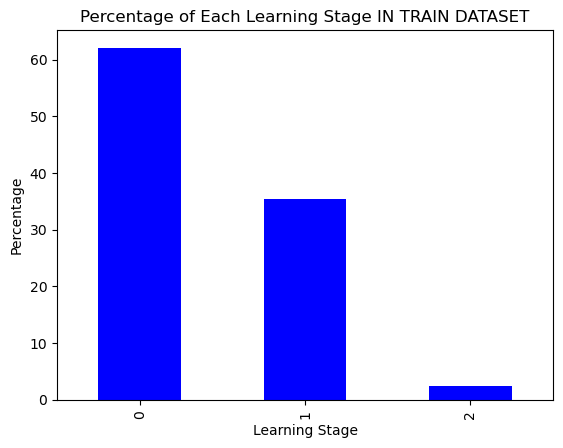

TRAIN AFTER OVERSAMPLING
Learning_stage IN TEST
learning stage = 0: 36138
learning stage = 1: 36138
learning stage = 2: 36138


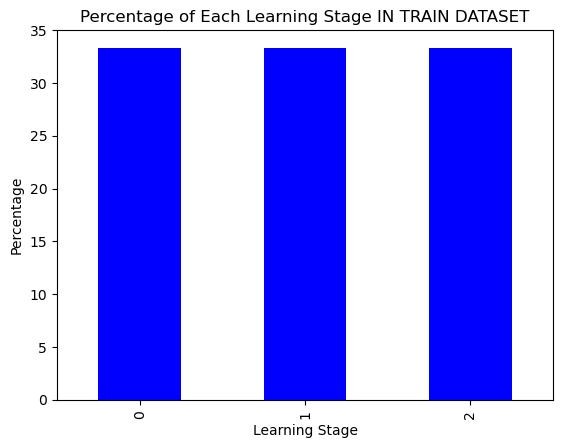

8674/8674 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.4526 - loss: 0.9759 - val_accuracy: 0.3910 - val_loss: 1.5148
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6020 - loss: 0.8276
Accuracy: 0.60
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


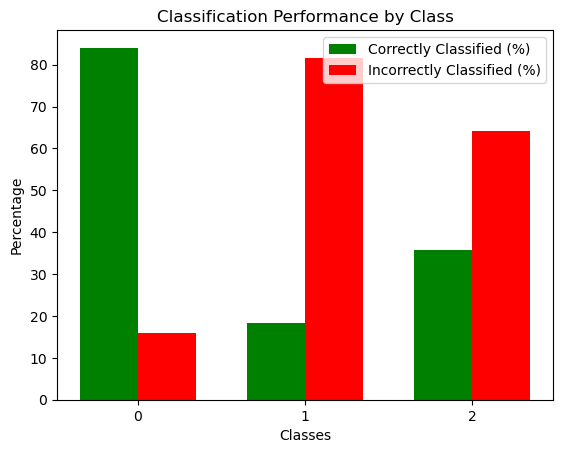

  Total Elements Correctly Classified Accuracy (%)
0           9035                 7595    84.061981
1           5156                  945    18.328161
2            361                  129    35.734072


In [ ]:
#MODEL1 WITH OVERSAMPLING
MODEL = ModelDataPreparer(result)
acc,dizio_info = MODEL.modelNN_classification_relu_oversampling(1,'learning_stage')
df_info = MODEL.evaluate_class_performance(dizio_info)
MODEL.plot_classification_performance(df_info)
print(df_info)

#MODEL2 WITH OVERSAMPLING
MODEL = ModelDataPreparer(result)
acc,dizio_info = MODEL.modelNN_classification_sigmoid_oversampling(1,'learning_stage')
df_info = MODEL.evaluate_class_performance(dizio_info)
MODEL.plot_classification_performance(df_info)
print(df_info)

# Task
Predict **when and why** a student will drop out or give up and look into possible methods to mitigate them.

- The student might completely stop using the online learning platform at all.
- The student might give up leveling up a certain exercise to proficient.
- The student might give up to answer the problem and just look through all the hints or guess all the possible answers.

### WHY?
#### Defining Student Dropout Risk

We aim to determine whether a student is likely to drop out based on specific criteria. We will use the following metrics to assign a binary label to each student:

- **`max_days_inactive`**: The maximum number of days a student has been inactive.
- **`total_sec_taken`**: The total time spent on exercises per encounter.
- **`is_correct`**: The number of correct answers given by the student.
- **`total_attempt_cnt`**: The total number of attempts the student has made for each problem.

#### Objective

We want to create a binary label, `dropout_label`, to indicate:

- **`dropout_label = 1`**: The student is likely to drop out.
- **`dropout_label = 0`**: The student is not likely to drop out.

#### Criteria for Dropout

To define whether a student will drop out, we will set thresholds for each metric. For example:

- **`max_days_inactive`**: A high number of inactive days may suggest a student is losing interest.
- **`total_sec_taken`**: Excessive time spent on exercises might indicate difficulty or frustration.
- **`is_correct`**: A low number of correct answers might reflect persistent struggles.
- **`total_attempt_cnt`**: A high number of attempts could signal ongoing difficulties.


In [ ]:
def set_condition(days_inactive, attempt_count, num_correct, hint_rate):

    result_finale_modelli['dropout_label'] = (result_finale_modelli['max_days_inactive'] > days_inactive).astype(int)

    result_finale_modelli['exercise_dropout_label'] = (result_finale_modelli['total_attempt_cnt'] > attempt_count) & (result_finale_modelli['is_correct'] == num_correct)

    result_finale_modelli['hint_use_rate'] = result_finale_modelli['used_hint_cnt'] / result_finale_modelli['total_attempt_cnt']
    result_finale_modelli['problem_dropout_label'] = (result_finale_modelli['hint_use_rate'] > hint_rate).astype(int)

    result_finale_modelli['dropout'] = (result_finale_modelli['dropout_label'] | result_finale_modelli['exercise_dropout_label'] | result_finale_modelli['problem_dropout_label']).astype(int)

    return result_finale_modelli

## Set values for the dataset
result_df = set_condition(210, 15, 0, 1)
result_df.head()

,uuid,badges_cnt,points,total_attempt_cnt,used_hint_cnt,total_sec_taken,is_correct,learning_stage,day,Numbers_of_login_for_user,max_days_inactive,unique_activity_days,dropout_label,exercise_dropout_label,hint_use_rate,problem_dropout_label,dropout
0,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,1,16725,5,0,302,5,1,2018-12-22,11813,221,1,1,False,0.000000,0,1
1,++9EkR6syMGk44XpyhOj40cg9xiXwCLS/TwEy+ujrL0=,3,1200,52,29,428,3,1,2019-05-22,11122,294,1,1,False,0.557692,0,1
2,++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,0,9533,16,5,898,7,0,2018-09-16,10949,318,1,1,False,0.312500,0,1
3,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,0,8027,52,54,1550,23,0,2018-12-02,8926,241,2,1,False,1.038462,1,1
4,++GobOSWqrsaxoRg1bMN+T6biIJcgBXwuOH/ddq3DiU=,2,41831,188,7,4943,137,1,2019-06-15,8772,255,3,1,False,0.037234,0,1


#### Target Variable: Dropout


In [ ]:
result_df["dropout"].value_counts()

dropout
1    45281
0    27477
Name: count, dtype: int64

### Split data in Train and Test sets


In [ ]:
## select variables
result_df = result_df[["badges_cnt", "points", "total_attempt_cnt", "used_hint_cnt","total_sec_taken", "is_correct", "learning_stage", "dropout"]]

X = result_df.drop(columns=['dropout'])
y = result_df['dropout']

# Split dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Multilayer Perceptron (MLP)
A Multilayer Perceptron (MLP) is a type of artificial neural network (ANN) that consists of multiple layers of nodes:

 - _Input Layer_: The first layer that receives the input data.
- _Hidden Layers_: One or more layers between the input and output layers where computations are performed. Each neuron in a hidden layer applies a weighted sum of the inputs, passes it through an activation function, and outputs the result to the next layer.
- _Output Layer_: The final layer that produces the prediction or classification result.

The data is typically normalized or standardized, for ensuring that each feature contributes equally to the model's performance, and after divided into training and testing sets. The training set is used to train the model, and the testing set is used to evaluate its performance. In particular, during training, the model learns to adjust the weights and biases in the network to minimize the error between the predicted and actual outputs. This is done using backpropagation and optimization algorithms.



In [ ]:
def mlp(X_train, X_test, y_train, epochs, batch_size, validation_split):
    model_mlp = Sequential()
    model_mlp.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model_mlp.add(Dense(32, activation='relu'))
    model_mlp.add(Dense(1, activation='sigmoid'))

    ## Compile MLP model
    model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    ## Train model
    history_mlp = model_mlp.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    # Prediction of P(Y=1|x)
    y_pred_prob = model_mlp.predict(X_test).ravel()

    return y_pred_prob

y_pred_prob = mlp(X_train, X_test, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7249 - loss: 0.5631 - val_accuracy: 0.7410 - val_loss: 0.5367
Epoch 2/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7386 - loss: 0.5408 - val_accuracy: 0.7424 - val_loss: 0.5355
Epoch 3/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7338 - loss: 0.5433 - val_accuracy: 0.7416 - val_loss: 0.5371
Epoch 4/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7408 - loss: 0.5362 - val_accuracy: 0.7439 - val_loss: 0.5332
Epoch 5/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7367 - loss: 0.5386 - val_accuracy: 0.7430 - val_loss: 0.5327
Epoch 6/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7413 - loss: 0.5353 - val_accuracy: 0.7445 - val_loss: 0.5321
Epoch 7/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7367 - loss: 0.5401 - val_accuracy: 0.7430 - val_loss: 0.5320
Epoch 8/20
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7355 - loss: 0.5393 - 

### ROC Curve and AUC
The **Receiver Operating Characteristic (ROC)** curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. It is possible to use the ROC curve to determine an appropriate threshold for binary classification.

The **Area Under the Curve (AUC)** is a single scalar value that summarizes the performance of a binary classification model. It represents the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. The AUC is derived from the ROC curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The AUC value ranges from 0 to 1.

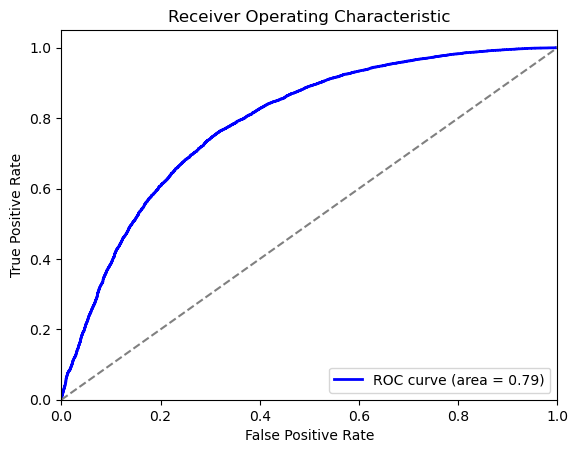

In [ ]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# F1 scores for each threshold
f1_scores = [f1_score(y_test, (y_pred_prob > t).astype(int)) for t in thresholds]

# Best threshold = max F1
best_threshold = thresholds[np.argmax(f1_scores)]

# Plot of ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Use the best threshold for predictions
y_pred_best = (y_pred_prob > best_threshold).astype(int)


The Area Under the Curve (AUC) of the ROC curve is 0.79, it indicates that the model has a good discriminative ability.It means there is a 79% chance that the model will correctly rank a randomly chosen positive instance higher than a randomly chosen negative one.

### Confusion Matrix
**Confusion Matrix** is a specific table layout that allows visualization of the performance of an algorithm.
Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. The diagonal of the matrix therefore represents all instances that are correctly predicted.


#### Metrics and Formulas

##### Precision
The ratio of true positive predictions to the total predicted positives.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Where:
- `TP` = True Positives
- `FP` = False Positives

##### Recall
The ratio of true positive predictions to the total actual positives.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Where:
- `TP` = True Positives
- `FN` = False Negatives

##### F1-Score
The harmonic mean of precision and recall.

$$
\text{F1-Score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}}
$$

##### Accuracy
The ratio of correctly predicted instances to the total instances.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Where:
- `TN` = True Negatives

#### Macro Average
The arithmetic mean of precision, recall, or F1-score calculated for each class individually.

$$
\text{Macro Average} = \frac{1}{N} \sum_{i=1}^{N} \text{Metric}_i
$$

Where:
- `N` = Number of classes
- `Metric_i` = Precision, recall, or F1-score for class `i`

#### Weighted Average
The average of precision, recall, or F1-score, weighted by the number of instances in each class.

$$
\text{Weighted Average} = \frac{1}{\sum_{i=1}^{N} n_i} \sum_{i=1}^{N} n_i \times \text{Metric}_i
$$

Where:
- `n_i` = Number of instances in class `i`
- `Metric_i` = Precision, recall, or F1-score for class `i`
- `N` = Number of classes



### Confusion Matrix of MLP

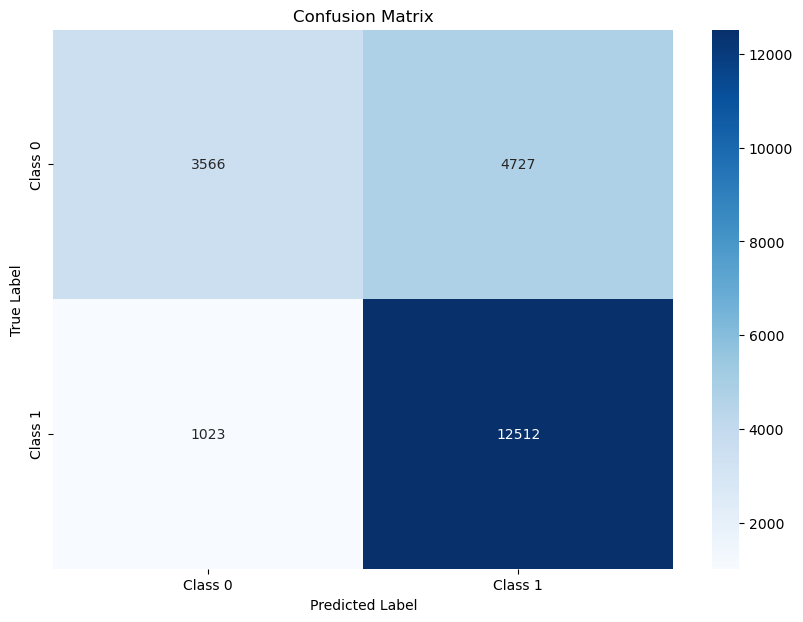

---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.43      0.55      8293
           1       0.73      0.92      0.81     13535

    accuracy                           0.74     21828
   macro avg       0.75      0.68      0.68     21828
weighted avg       0.75      0.74      0.71     21828



In [ ]:
# Confunsion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('---------------')
print("Classification Report:\n", classification_report(y_test, y_pred_best))


The model performs well for class 1, with high recall and a good F1-score, but it struggles with class 0, where the recall is relatively low. The overall accuracy is 0.74, indicating a good performance, but there is room for improvement, especially in correctly identifying class 0 instances. Balancing the dataset or using techniques like class weighting or oversampling/undersampling might help improve the performance for the minority class (class 0).

### Random Forest for Classification
A Random Forest is an ensemble learning method primarily used for classification and regression tasks. It operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) of the individual trees.

**Training the Random Forest Model:**

- _Bootstrapping_: Randomly select subsets of the training data with replacement to create multiple training datasets.
- _Decision Trees_: For each subset, a decision tree is built. Each tree is trained on a random sample of the training data and considers a random subset of features when splitting nodes.
- _Aggregation_: During prediction, each tree in the forest makes a classification, and the class with the most votes is selected as the final prediction.


In [ ]:
def random_forest(X_train, X_test, y_train, n_estimators, random_state):
    model_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train model
    model_rf.fit(X_train, y_train)

    y_pred_rf = model_rf.predict(X_test)

    return y_pred_rf

y_pred_rf = random_forest(X_train, X_test, y_train, n_estimators=100, random_state=42)

 ### ROC Curve and AUC for Random Forest

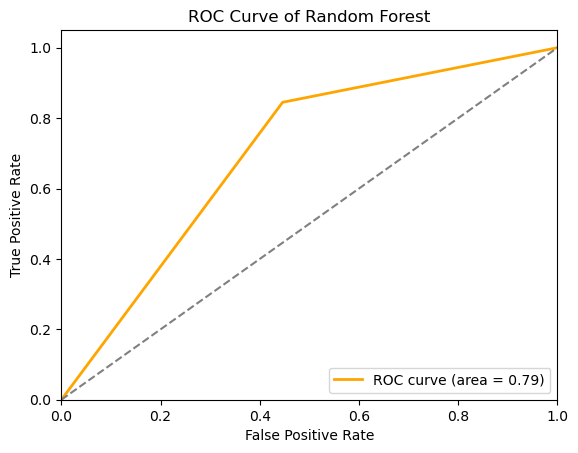

In [ ]:
# ROC Curve and AUC
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_rf)
roc_auc1 = auc(fpr1, tpr1)

# F1 scores for each threshold
f1_scores1 = [f1_score(y_test, (y_pred_rf > t).astype(int)) for t in thresholds]

# Best threshold = max F1
best_threshold = thresholds[np.argmax(f1_scores1)]

# Plot of ROC Curve
plt.figure()
plt.plot(fpr1, tpr1, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.legend(loc="lower right")
plt.show()

# Use the best threshold for predictions
y_pred_best1 = (y_pred_rf > best_threshold).astype(int)

### Confusion Matrix of Random Forest


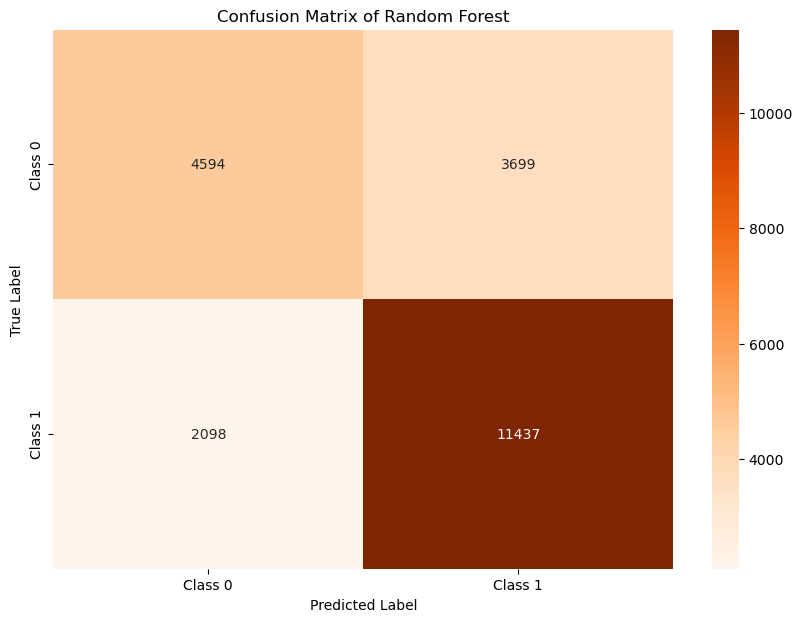

---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.55      0.61      8293
           1       0.76      0.84      0.80     13535

    accuracy                           0.73     21828
   macro avg       0.72      0.70      0.71     21828
weighted avg       0.73      0.73      0.73     21828



In [ ]:
# Confunsion matrix
cm = confusion_matrix(y_test, y_pred_best1)

# Heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=True,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Random Forest')
plt.show()

print('---------------')
print("Classification Report:\n", classification_report(y_test, y_pred_best1))

### Model Comparison: MLP vs. Random Forest

#### Precision and Recall
- **MLP** shows better precision for class 0 and higher recall for class 1 compared to Random Forest.
- **Random Forest** exhibits better recall for class 0 and a more balanced performance with higher F1-scores for both classes.

#### Overall Accuracy
- The overall accuracy of the MLP model is slightly better than that of the Random Forest model. However, the difference in accuracy between the two models is minimal.

We prefer the Random Forest model because it can effectively capture both classes, despite their imbalance. It provides a more balanced performance overall, which is crucial given the uneven distribution of the classes.


 ### WHEN?

In [ ]:
df_merged.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,...,content_pretty_name,content_kind,difficulty,subject,learning_stage,level1_id,level2_id,level3_id,level4_id,day
0,2019-05-26 21:00:00+00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,2,True,33,1,0,...,【一般】含乘方的四則運算,Exercise,normal,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,/yqeM1FRP1rB9WuQWBkStMqrBQgjEexaeyWIhBC7ov4=,3jxSic/zhR8AsGYosBmwxHpD3CCxpEZRMKGWPQ0pmG8=,2019-05-26
1,2019-06-14 22:15:00+00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,5FL1HMWd+W5BjlVpdk4v/iMnA2LJ5zCmi4B34bvwb/4=,20,1,True,731,1,0,...,【一般】含乘方的四則運算,Exercise,normal,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,/yqeM1FRP1rB9WuQWBkStMqrBQgjEexaeyWIhBC7ov4=,3jxSic/zhR8AsGYosBmwxHpD3CCxpEZRMKGWPQ0pmG8=,2019-06-14
2,2019-04-01 21:00:00+00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,544mqzF4HGIH+HQOJqoLBRLTXnwRDGI/VYwRCmXRD8g=,8,1,True,30,1,0,...,【一般】含乘方的四則運算,Exercise,normal,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,/yqeM1FRP1rB9WuQWBkStMqrBQgjEexaeyWIhBC7ov4=,3jxSic/zhR8AsGYosBmwxHpD3CCxpEZRMKGWPQ0pmG8=,2019-04-01
3,2019-04-01 21:00:00+00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,1,1,True,78,1,0,...,【一般】含乘方的四則運算,Exercise,normal,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,/yqeM1FRP1rB9WuQWBkStMqrBQgjEexaeyWIhBC7ov4=,3jxSic/zhR8AsGYosBmwxHpD3CCxpEZRMKGWPQ0pmG8=,2019-04-01
4,2019-04-01 21:00:00+00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,wqcEbbUAf08EWfHskagwQ+m6Ff6PoegvxpRpfU5vbBc=,6,1,True,37,1,0,...,【一般】含乘方的四則運算,Exercise,normal,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,/yqeM1FRP1rB9WuQWBkStMqrBQgjEexaeyWIhBC7ov4=,3jxSic/zhR8AsGYosBmwxHpD3CCxpEZRMKGWPQ0pmG8=,2019-04-01


#### Function for creating new dataset

In [ ]:
class Processing:

    def mode(self, df, variables):
        # Create a copy of the DataFrame to avoid SettingWithCopyWarning
        df_copy = df.copy()

        # Convert 'timestamp_TW' to datetime format and drop rows with invalid dates
        df_copy['timestamp_TW'] = pd.to_datetime(df_copy['timestamp_TW'], errors='coerce')
        df_copy = df_copy.dropna(subset=['timestamp_TW'])

        # Create a new DataFrame with 'timestamp_TW' and the variables of interest
        new_df = df_copy[['timestamp_TW'] + variables].copy()

        # Extract the date part of 'timestamp_TW' to group by day
        new_df['day'] = new_df['timestamp_TW'].dt.date

        result_list = []

        # Loop through each variable to compute the mode per day
        for variable in variables:
            grouped = new_df.groupby('day')[variable].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
            grouped.columns = ['day', variable + '_mode']
            result_list.append(grouped)

        # Concatenate all the results into a single DataFrame
        final_df = result_list[0]
        for df in result_list[1:]:
            final_df = pd.merge(final_df, df, on='day', how='outer')

        # Rename the columns for clarity
        final_df.columns = ['day'] + [f'{var}_mode' for var in variables]

        return final_df


    def groupby_operations1(self, df, variables, operations):

        new_df = df[['timestamp_TW'] + variables].copy()
        new_df['timestamp_TW'] = pd.to_datetime(new_df['timestamp_TW'], errors='coerce')
        new_df = new_df.sort_values(by='timestamp_TW')
        new_df['day'] = new_df['timestamp_TW'].dt.date

        agg_dict = {variables[i]: operations[i] for i in range(len(variables))}
        grouped_df = new_df.groupby('day').agg(agg_dict).reset_index()

        return grouped_df



In [ ]:
'''
ALREADY CREATED

variables = ['uuid', 'problem_number', 'total_sec_taken', 'used_hint_cnt', 'points', 'badges_cnt' ]
operations = ['count', 'sum', 'mean', 'median', 'mean', 'median']

variables_for_mode = ['is_correct', 'user_grade','difficulty', 'learning_stage']

p = Processing()
result1 = p.groupby_operations1(df_merged,variables,operations)
result2 = p.mode(df_merged, variables_for_mode)

result = pd.merge(result1, result2, on='day', how='inner')

# Save dataset
result.to_csv('result_finalissimo.csv', index=True)
'''



### _____________________________________________________________________________________________

In [ ]:
result = pd.read_csv('result.csv')
result['day'] = pd.to_datetime(result['day'])
result.set_index('day', inplace=True)
result = result.drop('Unnamed: 0', axis = 1)
result.head()


,uuid,problem_number,total_sec_taken,used_hint_cnt,points,badges_cnt,is_correct_mode,user_grade_mode,difficulty_mode,learning_stage_mode
day,,,,,,,,,,
2018-08-01,3513,21414,39.753202,0.0,98643.351836,7.0,True,6,easy,elementary
2018-08-02,6168,46768,38.243353,0.0,87873.723249,8.0,True,6,easy,elementary
2018-08-03,6811,53161,40.045661,0.0,124636.824108,11.0,True,6,easy,elementary
2018-08-04,2327,14149,44.019338,0.0,147224.016760,8.0,True,4,easy,elementary
2018-08-05,2781,18688,37.910104,0.0,131043.950737,8.0,True,4,easy,elementary


### Distribution of numerical and categorical variables

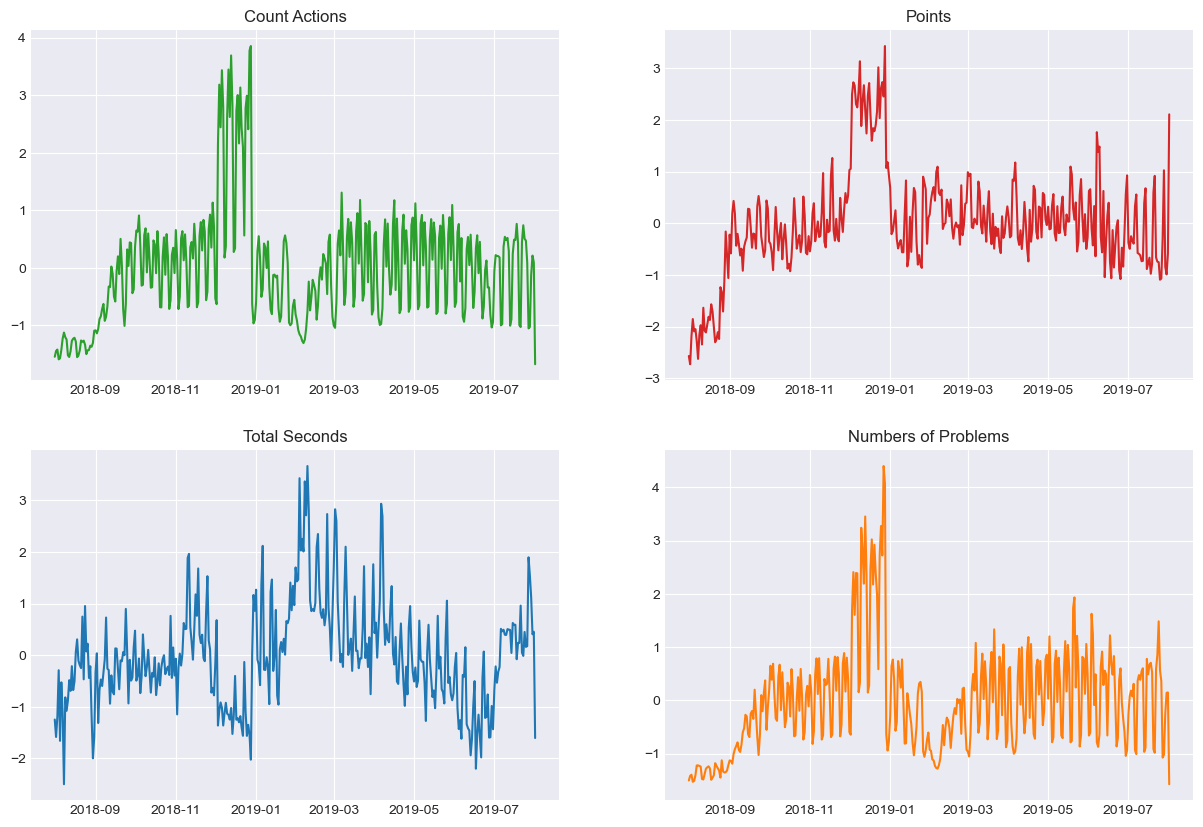

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns

# Plot on each subplot
axs[0, 0].plot(result.uuid ,'tab:green')
axs[0, 0].set_title('Count Actions')

axs[0, 1].plot(result.points, 'tab:red')
axs[0, 1].set_title('Points')

axs[1, 0].plot(result.total_sec_taken,'tab:blue')
axs[1, 0].set_title('Total Seconds')

axs[1, 1].plot(result.problem_number ,'tab:orange')
axs[1, 1].set_title('Numbers of Problems')

plt.show()


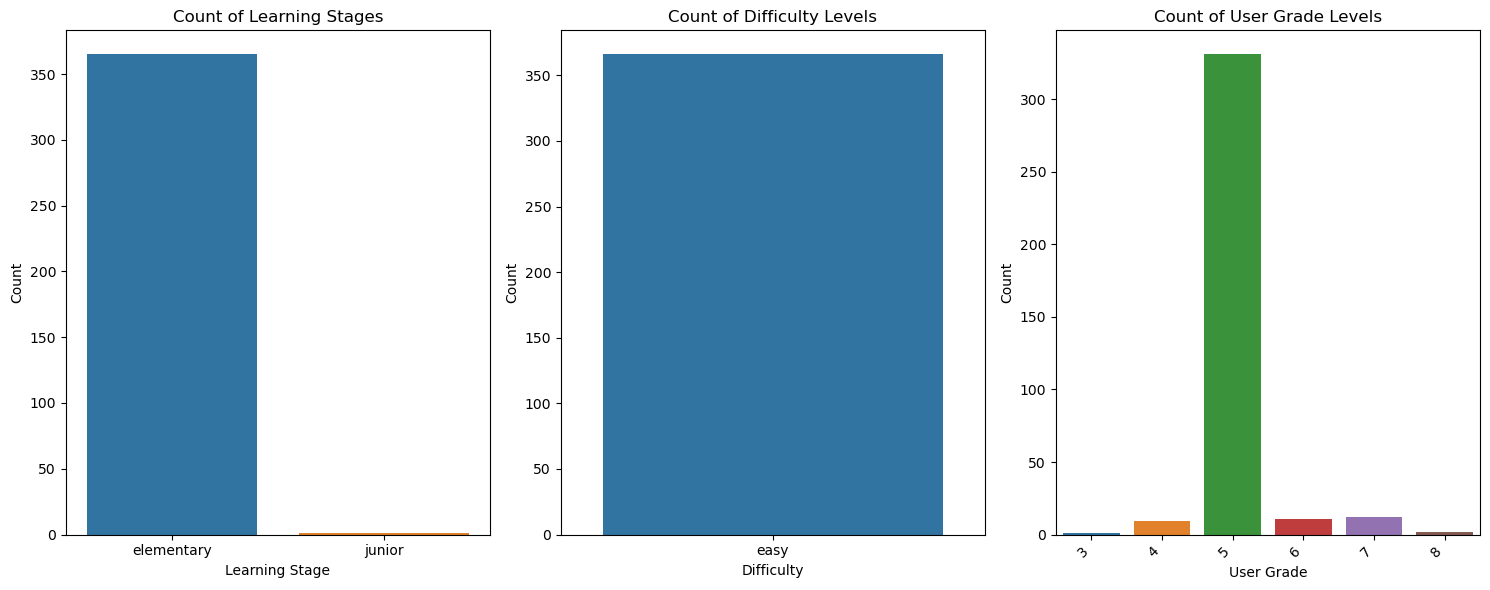

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# Barplot per 'learning_stage_mode' sul primo subplot (ax1)
sns.countplot(data=result, x='learning_stage_mode', ax=ax1)
ax1.set_xlabel('Learning Stage')
ax1.set_ylabel('Count')
ax1.set_title('Count of Learning Stages')

# Barplot per 'difficulty_mode' sul secondo subplot (ax2)
sns.countplot(data=result, x='difficulty_mode', ax=ax2)
ax2.set_xlabel('Difficulty')
ax2.set_ylabel('Count')
ax2.set_title('Count of Difficulty Levels')

# Barplot per 'user_grade_mode' sul terzo subplot (ax3)
sns.countplot(data=result, x='user_grade_mode', ax=ax3)
user_grades = result['user_grade_mode'].unique()  # Get unique user grade values
user_grades.sort()  # Sort if needed
ax3.set_xticks(range(len(user_grades)))  # Set x-ticks to match the number of unique grades
ax3.set_xticklabels(user_grades, rotation=45, ha='right')  # Rotate labels if needed
ax3.set_xlabel('User Grade')
ax3.set_ylabel('Count')
ax3.set_title('Count of User Grade Levels')


# Spaziatura tra i subplot
plt.tight_layout()

# Mostra i grafici
plt.show()


### Correlation between past and present [ACF - PACF]

`Autocorrelation`

It measures the level of resemblance (similarity) between a sequence from several periods ago and actual data.


In short ACF measures the correlation between observations of a time series separated by (k) time units i.e lags. The formula for the ACF at lag (k) is:

$$
\rho_k = \frac{\sum_{t=k+1}^{n} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{n} (y_t - \bar{y})^2}
$$

where:

•$y_t$: is the value of the time series at time $(t)$,

•$\bar{y}$: is the mean of the time series,

•$n$: is the number of observations.

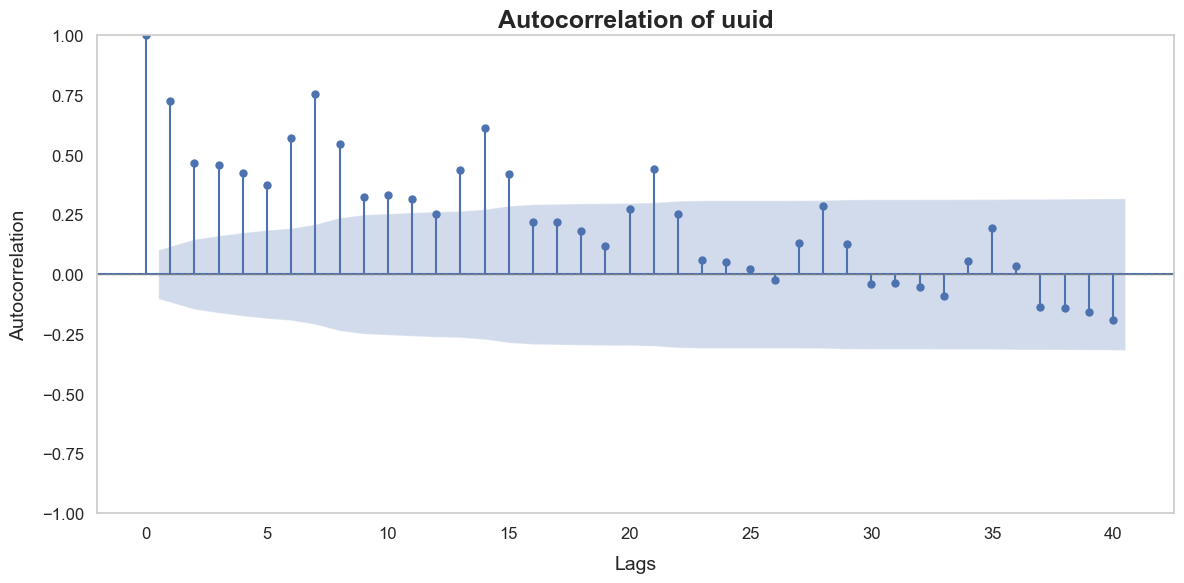

In [ ]:
# Plotting the Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(12, 6))
sgt.plot_acf(result.uuid, lags=40, ax=ax)

# Enhancing the plot appearance
ax.set_title("Autocorrelation of uuid", fontsize=18, fontweight='bold')
ax.set_xlabel("Lags", fontsize=14, labelpad=10)
ax.set_ylabel("Autocorrelation", fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

# Setting the background color to white
ax.set_facecolor('white')

# Removing the grid
ax.grid(False)

# Adding a horizontal line at y=0 for reference
ax.axhline(y=0, linestyle='--', color='gray', linewidth=1)

# Adjust layout to give more space around the plot
plt.tight_layout()

# Show the plot
plt.show()

The ACF shows significant correlation only at the first lag and decreases rapidly for subsequent lags.
We can also see highly significant lags every 4 time periods. This could be indicative of an ARIMA or SARIMA model (with low q value).


`Partial Autocorrelation Function`

This measures the correlation between a time series and lagged versions of itself but after eliminating the variations already explained by the intervening comparisons. Essentially, PACF at lag 2 would measure the correlation between the series and its lagged version two time points back, but removing the effects of lags 1.

The PACF at lag (k) can be calculated using the Durbin-Levinson algorithm, but a simplified representation is:

$$
\phi_{kk} = \frac{\rho_k - \sum_{j=1}^{k-1} \phi_{k-1,j} \rho_{k-j}}{1 - \sum_{j=1}^{k-1} \phi_{k-1,j} \rho_j}
$$

where:

•$\phi_{kk}$: is the PACF at $lag (k)$,

•$\rho_k$: is the ACF at $lag k$,

•$\phi_{k-1,j}$ :are the PACF values for previous lags.

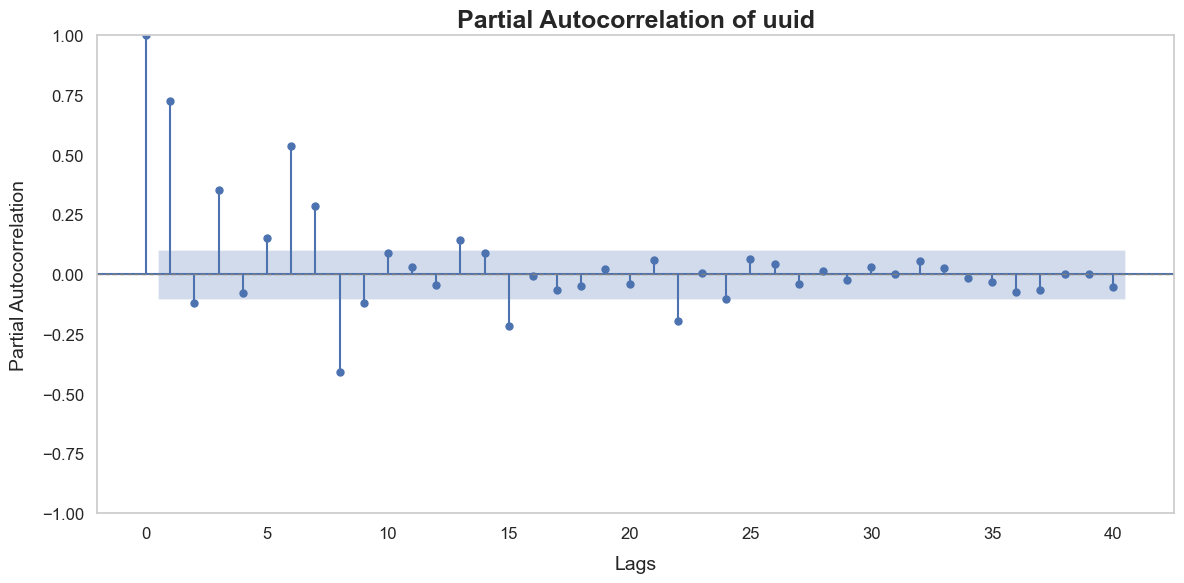

In [ ]:
# Plotting the Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(12, 6))
sgt.plot_pacf(result.uuid, lags=40, ax=ax)

# Enhancing the plot appearance
ax.set_title("Partial Autocorrelation of uuid", fontsize=18, fontweight='bold')
ax.set_xlabel("Lags", fontsize=14, labelpad=10)
ax.set_ylabel("Partial Autocorrelation", fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

# Setting the background color to white
ax.set_facecolor('white')

# Removing the grid
ax.grid(False)

# Adding a horizontal line at y=0 for reference
ax.axhline(y=0, linestyle='--', color='gray', linewidth=1)

# Adjust layout to give more space around the plot
plt.tight_layout()

# Show the plot
plt.show()

PACF shows two significant lags.

### Additive Decomposition

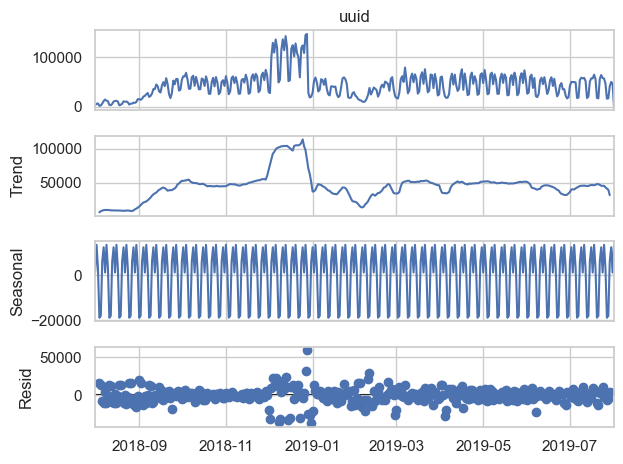

In [ ]:
s_dec_additive = seasonal_decompose(result.uuid, model = "additive")
# plot the graphs
s_dec_additive.plot()
plt.show()

This plot shows the additive decomposition of the time series, in particular related to the variable uuid. Additive decomposition breaks down the time series into 3 components: **Trend, Seasonal and Residual**. These three components, shown separately in the three lower panels, can be added to reconstruct the original data, shown in the top panel.


$$
\ y_t = \ S_{t} + \ T_{t} + \ R_{t}
$$

In particular,
- The Trend Component indicates an overall increase of students’ actions from mid-2018 to early 2019, followed by some fluctuations and a gradual decline towards mid-2019.
- The Seasonal Component occurs when a time series is influenced by periodic factors, such as the time of year or day of the week. In this case, the strong periodic oscillations indicate a consistent seasonal pattern within the data. This pattern might be associated with the daily activity on the platform, where actions start in the morning and end in the afternoon or evening.
- The Residual Component is the remaining part of the series after removing the trend and seasonal components. These represent the irregularities or noise in the data. The residuals seem to be relatively small and scattered randomly, indicating that most of the variability in the series is accounted for by the trend and seasonal components.


### Check the Stationarity
#### ADF - Test
The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or has a unit root, which implies non-stationarity. The ADF test is an extension of the Dickey-Fuller test and includes lagged differences of the time series to account for higher-order autoregressive processes.

ADF Test Equations
The ADF test can be represented by the following regression equations:

1. Without a constant and trend:
$$
\Delta y_t = \gamma y_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta y_{t-i} + \epsilon_t
$$
2. With a constant:
$$
\Delta y_t = \beta_0 + \gamma y_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta y_{t-i} + \epsilon_t
$$
3. With a constant and a trend:
$$
\Delta y_t = \beta_0 + \beta_1 t + \gamma y_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta y_{t-i} + \epsilon_t
$$

Where:

•$\Delta y_t$: is the first difference of the time series $y_t$,

•$\beta_0$: is the intercept,

•$\beta_1$: is the coefficient on the time trend,

•$\gamma$: is the coefficient of $y_{t-1}$ i.e the lagged level of the series,

•$\alpha_i$: are the coefficients of the lagged differences,

•$\epsilon_t$: is the error term,

•$p$: is the number of lagged differences included in the model.

Hypotheses:

1.Null Hypothesis (H0): The time series has a unit root (non-stationary).

2.Alternative Hypothesis (H1): The time series is stationary.

In [ ]:
## Check the stationarity: ADF-Test
result_adf = adfuller(result['uuid'])

#results:
adf_statistic = result_adf[0]
p_value = result_adf[1]
used_lag = result_adf[2]
n_obs = result_adf[3]
critical_values = result_adf[4]
icbest = result_adf[5]

print('Test di Dickey-Fuller aumentato (ADF)')
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Lags Used:', used_lag)
print('Number of Observations Used:', n_obs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

if p_value < 0.05:
    print("The time series is stationary (we reject the null hypothesis)")
else:
    print("The time series is not stationary (we do not reject the null hypothesis)")


Test di Dickey-Fuller aumentato (ADF)
ADF Statistic: -2.6778038929929164
p-value: 0.07795854769429272
Lags Used: 14
Number of Observations Used: 351
Critical Values:
   1%: -3.44911857009962
   5%: -2.8698097654570507
   10%: -2.5711757061225153
The time series is not stationary (we do not reject the null hypothesis)


### Handling Not-Stationarity
### Differentiation

Differentiation is the most common method to address non-stationarity. It involves calculating the difference between consecutive values in the time series.

**First-order Differentiation:**

$$ Y_t^{(1)} = Y_t - Y_{t-1} $$


### Scaling the features with Standardization

Standardization is a method for transforming variables so that they have a mean of 0 and a standard deviation of 1. This process is particularly useful for algorithms sensitive to the scale of variables.


Given a variable $X$, the standardization of $X$ is defined as:


$$Z = \frac{x - \mu}{\sigma}$$

where:
- $ \mu $ is the mean of the variable $X$,
- $\sigma$ is the standard deviation of the variable $X$,



In [ ]:
# Select only numerical variables
numeric_features = result.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()

result[numeric_features] = scaler.fit_transform(result[numeric_features])


### Split Train and Test Sets

In [ ]:
# Splitting the data without shuffling
train, test = train_test_split(result, test_size=0.2, shuffle=False)

## Models

### ARIMA


The ARIMA model stands for Autoregressive Integrated Moving Average used for forecasting and analyzing time series data. The "order" in ARIMA refers to the specific parameters (p, d, q) that define the model structure:

**Autoregressive(AR):p**
This part of the model captures the relationship between an observation and a certain number of lagged observations i.e. Number of Autoregressive terms.
Mathematically, it can be represented as:
$$ AR(p): Y_t = \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + ... + \alpha_p Y_{t-p} + \epsilon_t $$

**Integration(I):d**
This represents the differencing steps needed to make the series stationary, which means constant mean and variance over time i.e. Number of non-seasonal differences needed for stationarity.
A first difference of the series ( Y ) is:
$$ I(d): \nabla Y_t = Y_t - Y_{t-1} $$
**Note** Remember Higher order differences can be represented as $$ ( \nabla^d Y_t ) $$.

**Moving Average(MA):q**
This part models the relationship between an observation and a residual error from a moving average model applied to lagged observations i.e. Number of lagged forecast errors in the prediction equation.
It is given by:
$$ MA(q): Y_t = \epsilon_t + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + ... + \beta_q \epsilon_{t-q} $$
where:  
$ \epsilon_t $ is the white noise error term   
$ \beta_1, \beta_2, ..., \beta_q $ are the parameters of the model.


In [ ]:
order = (4, 1, 7)  ## (p,d,q)
model_arima = sm.tsa.arima.ARIMA(train.uuid, order=order)

# Fit the ARIMA model
results_arima = model_arima.fit()

# Print summary of the model
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   uuid   No. Observations:                  292
Model:                 ARIMA(4, 1, 7)   Log Likelihood                -179.117
Date:                Tue, 23 Jul 2024   AIC                            382.235
Time:                        18:56:16   BIC                            426.315
Sample:                    08-01-2018   HQIC                           399.894
                         - 05-19-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7956      0.019     41.589      0.000       0.758       0.833
ar.L2         -1.4260      0.018    -80.308      0.000      -1.461      -1.391
ar.L3          0.8012      0.018     45.298      0.0

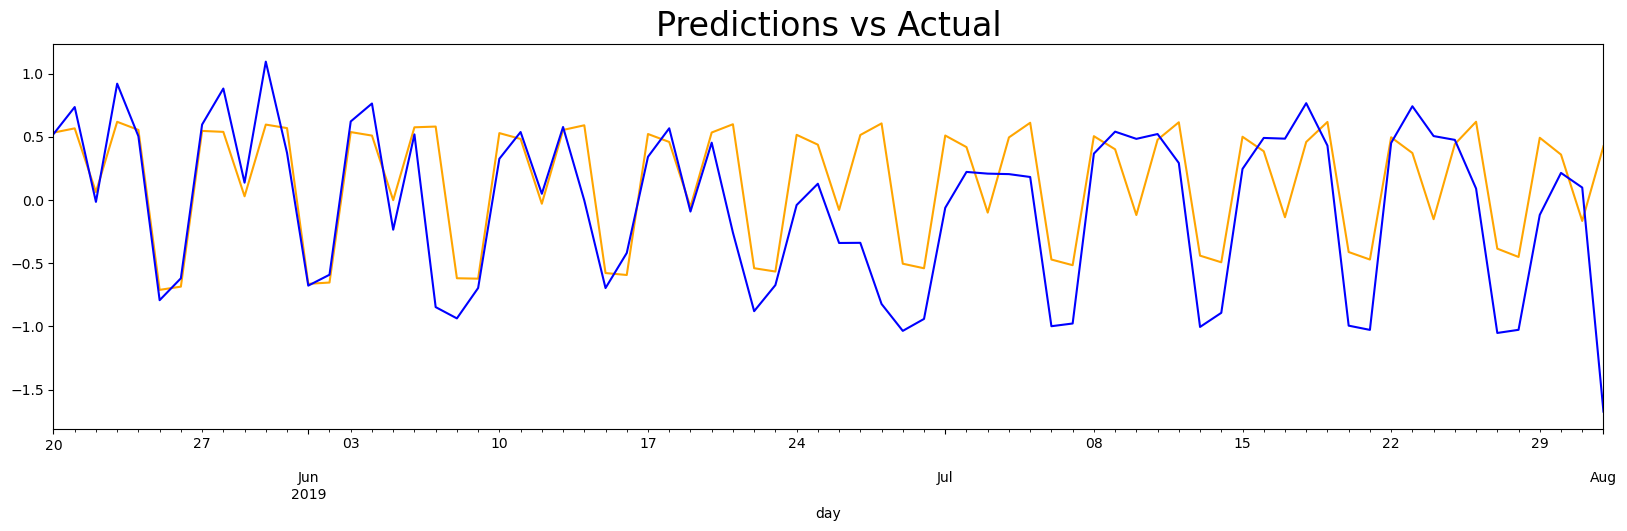

In [ ]:
# Define start and end dates for the prediction
start_date = test.index[0]
end_date = test.index[-1]

df_pred = results_arima.predict(start = start_date, end = end_date)

## Plot the results
df_pred[start_date:end_date].plot(figsize = (20,5), color = "orange")
test.uuid[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### ARIMAX

The ARIMAX model, which stands for Autoregressive Integrated Moving Average with eXogenous inputs, is an extension of the ARIMA model. It incorporates external variables (X), also known as exogenous variables, into the forecasting equation. These variables can be anything that might influence or affect the values we are trying estimate.

Below is a breakdown of the ARIMAX model:

•**AR**: Autoregressive part, as in ARIMA, which uses the dependency between an observation and a number of lagged observations.

•**I**: Integrated part, which involves differencing the time series to achieve stationarity.

•**MA**: Moving Average part, which uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

•**X**: Exogenous variables, which are external factors that can influence the time series.

The mathematical formulation of an ARIMAX model can be represented as:
$$ Y_t = c + \phi_1 Y_{t-1} + ... + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} + \beta_1 X_{t-1} + ... + \beta_k X_{t-k} + \epsilon_t $$
where:   
•  $(Y_t)$ is the time series value at time (t).

•  $(c)$ is a constant.

•$ \phi_1, ..., \phi_p $ :are the coefficients for the autoregressive terms.

•$ \theta_1, ..., \theta_q $ :are the coefficients for the moving average terms.

•$ \beta_1, ..., \beta_k $ :are the coefficients for the exogenous variables.

•$ X_{t-1}, ..., X_{t-k} $ :are the lagged values of the exogenous variables.

•$ \epsilon_t $ :is the error term at time (t)

In [ ]:
# Fit ARIMA model with exogenous variables (ARIMAX)
model_ret_armax = ARIMA(train['uuid'][1:], exog=train[['total_sec_taken', 'points', 'badges_cnt', 'problem_number']][1:], order=order)
results_ret_armax = model_ret_armax.fit()

print(results_ret_armax.summary())



                               SARIMAX Results                                
Dep. Variable:                   uuid   No. Observations:                  291
Model:                 ARIMA(4, 1, 7)   Log Likelihood                 151.592
Date:                Tue, 23 Jul 2024   AIC                           -271.184
Time:                        18:57:44   BIC                           -212.466
Sample:                    08-02-2018   HQIC                          -247.659
                         - 05-19-2019                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
total_sec_taken    -0.0236      0.016     -1.501      0.133      -0.054       0.007
points              0.0122      0.019      0.639      0.523      -0.025       0.049
badges_cnt         -0.0211      

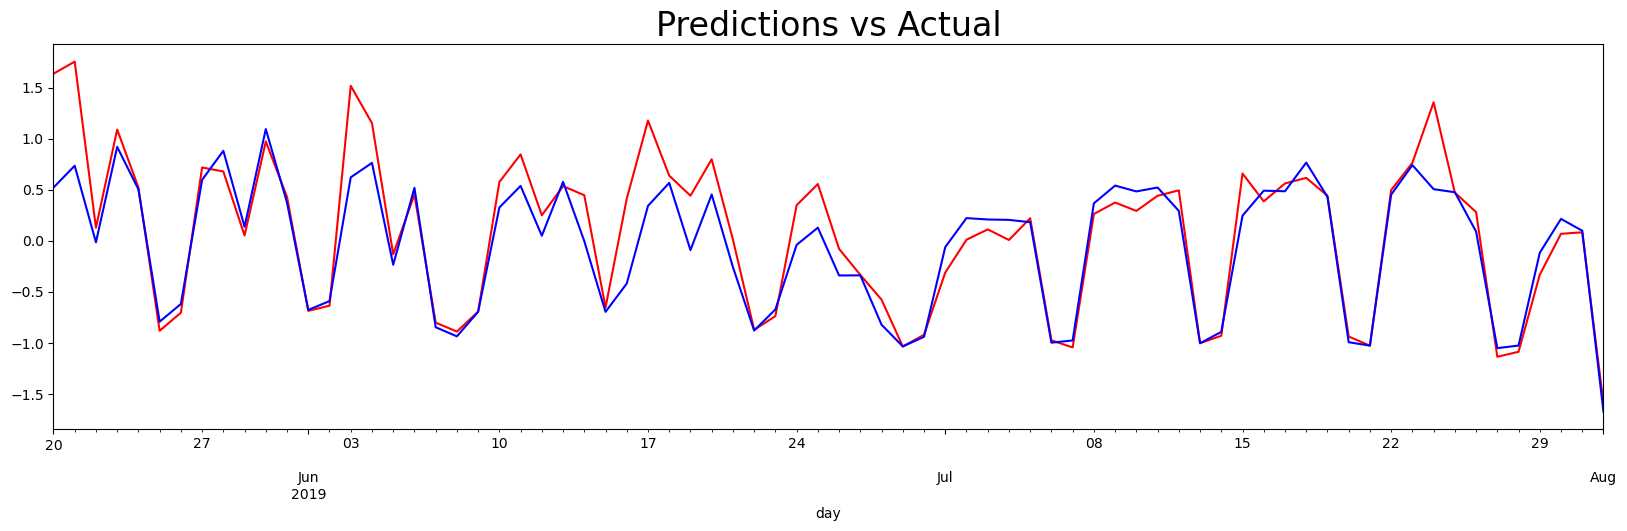

In [ ]:
# Make predictions
df_pred_armax = results_ret_armax.predict(start=start_date, end=end_date, exog=test[['total_sec_taken', 'points', 'badges_cnt', 'problem_number']])

# Plot the results
df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
test.uuid[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### SARIMAX

The SARIMAX model, which stands for Seasonal Autoregressive Integrated Moving Average with eXogenous variables, is an advanced version of the ARIMA and ARIMAX models. It's designed to handle time series data that exhibits both non-seasonal and seasonal patterns, and it also includes external factors that could influence the series.

Here's a breakdown of the SARIMAX model components:

•  Seasonal Component (S): This captures the periodic patterns in the data, such as weekly, monthly, or yearly cycles.
•  Autoregressive Component (AR): Represents the relationship between the current value and previous values in the time series.

•  Integrated Component (I): Involves differencing to make the time series stationary by removing trends and seasonality.

•  Moving Average Component (MA): Accounts for the dependency of the current value on past error terms, used to calculate trend.

•  Exogenous Regressors (X): Allows the inclusion of external variables that may affect the time series.

Mathematically, the SARIMAX model can be represented as:
$$
\begin{aligned}
& SARIMAX(p, d, q)(P, D, Q)_m =
(1 - \Phi_1 B^m - ... - \Phi_P B^{mP})(1 - \phi_1 B - ... - \phi_p B^p)(1 - B)^d Y_t = \
(1 + \Theta_1 B^m + ... + \Theta_Q B^{mQ})(1 + \theta_1 B + ... + \theta_q B^q) \epsilon_t + \beta X_t
\end{aligned}
$$
where:

•$p, d, q$: are the non-seasonal orders (as in ARIMA).

•$P, D, Q$: are the seasonal orders of the ARIMA model.

•$m$: is the number of periods in each season.

•$B$: is the backshift operator.

•$\Phi, \phi $: are the seasonal and non-seasonal autoregressive parameters.

•$\Theta, \theta$: are the seasonal and non-seasonal moving average parameters.

•$\beta$: represents the coefficients of the exogenous variables (X_t)

In [ ]:
### seasonal_order = (1,1,1,7) (P,D,Q,s)
model_ret_sarimax = SARIMAX(train.uuid[1:], exog = train[['total_sec_taken', 'points', 'badges_cnt', 'problem_number']][1:],
                            order = (4, 1, 7), seasonal_order = (1,1,1,12))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date,
                                              exog = test[['total_sec_taken', 'points', 'badges_cnt', 'problem_number']][start_date:end_date])

print(results_ret_sarimax.summary())




                                      SARIMAX Results                                       
Dep. Variable:                                 uuid   No. Observations:                  291
Model:             SARIMAX(4, 1, 7)x(1, 1, [1], 12)   Log Likelihood                 122.391
Date:                              Tue, 23 Jul 2024   AIC                           -208.782
Time:                                      18:57:59   BIC                           -143.485
Sample:                                  08-02-2018   HQIC                          -182.586
                                       - 05-19-2019                                         
Covariance Type:                                opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
total_sec_taken    -0.0304      0.017     -1.791      0.073      -0.064       0.003
poin

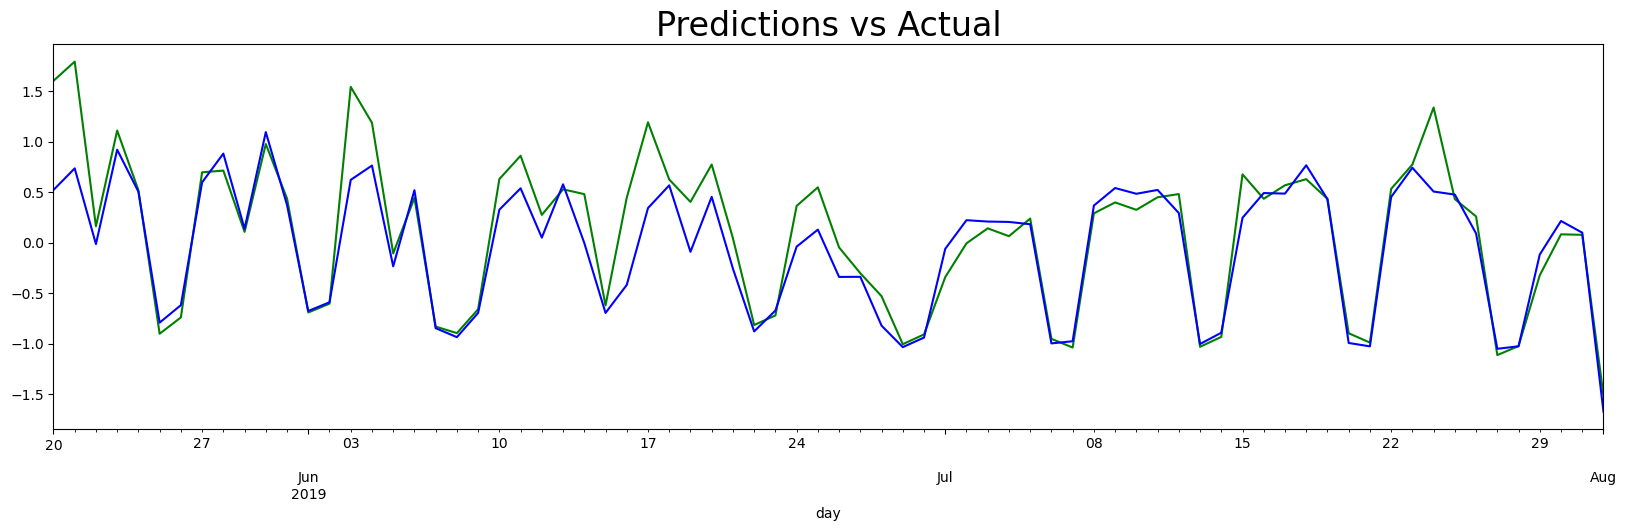

In [ ]:
# Plot the results
df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "green")
test.uuid[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

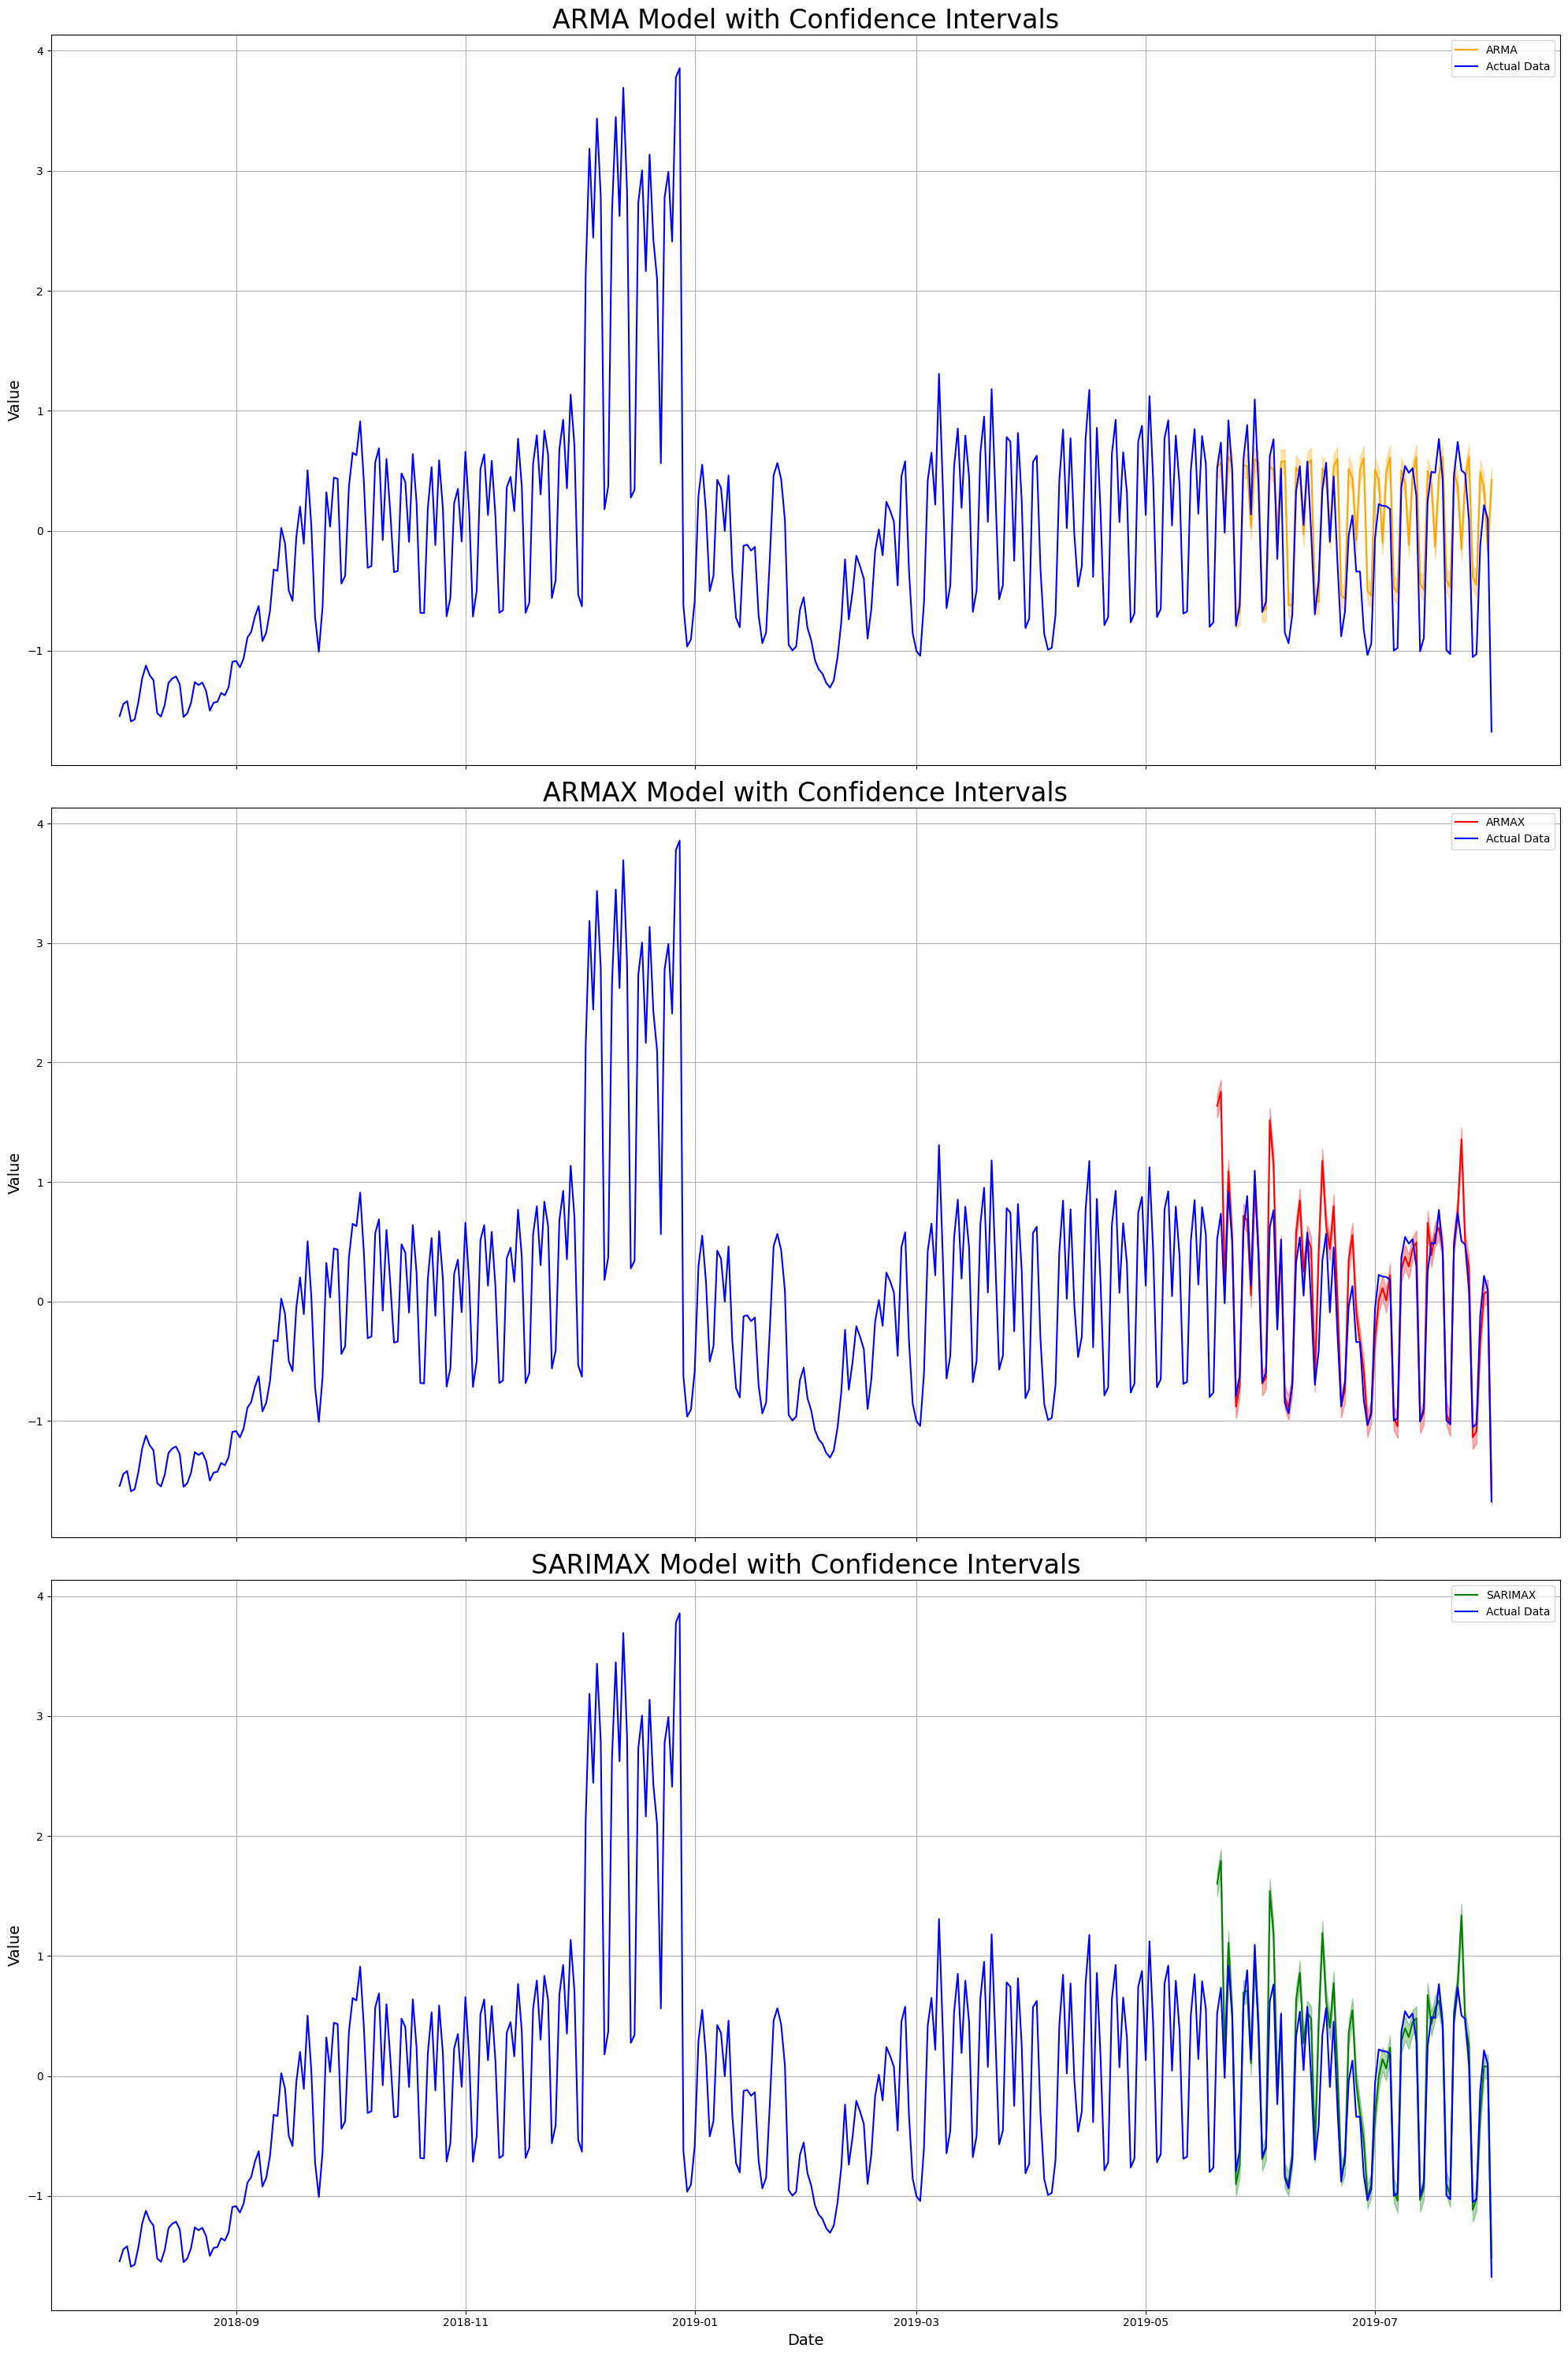

In [ ]:
# Confidence interval
df_pred_upper = df_pred + 0.1
df_pred_lower = df_pred - 0.1
df_pred_armax_upper = df_pred_armax + 0.1
df_pred_armax_lower = df_pred_armax - 0.1
df_pred_sarimax_upper = df_pred_sarimax + 0.1
df_pred_sarimax_lower = df_pred_sarimax - 0.1

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 30), sharex=True)

# ARIMA
axs[0].plot(df_pred.index, df_pred, color="orange", label='ARMA')
axs[0].fill_between(df_pred.index, df_pred_lower, df_pred_upper, color="orange", alpha=0.3)
axs[0].plot(result.index, result.uuid, color="blue", label='Actual Data')
axs[0].set_title('ARMA Model with Confidence Intervals', size=24)
axs[0].set_ylabel('Value', size=14)
axs[0].legend()
axs[0].grid(True)

# ARIMAX
axs[1].plot(df_pred_armax.index, df_pred_armax, color="red", label='ARMAX')
axs[1].fill_between(df_pred_armax.index, df_pred_armax_lower, df_pred_armax_upper, color="red", alpha=0.3)
axs[1].plot(result.index, result.uuid, color="blue", label='Actual Data')
axs[1].set_title('ARMAX Model with Confidence Intervals', size=24)
axs[1].set_ylabel('Value', size=14)
axs[1].legend()
axs[1].grid(True)

# SARIMAX
axs[2].plot(df_pred_sarimax.index, df_pred_sarimax, color="green", label='SARIMAX')
axs[2].fill_between(df_pred_sarimax.index, df_pred_sarimax_lower, df_pred_sarimax_upper, color="green", alpha=0.3)
axs[2].plot(result.index, result.uuid, color="blue",  label='Actual Data')
axs[2].set_title('SARIMAX Model with Confidence Intervals', size=24)
axs[2].set_xlabel('Date', size=14)
axs[2].set_ylabel('Value', size=14)
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


#### Select Best model
**Information Criteria**

For comparing models we calculate the AIC and BIC for each model. In particular:

- AIC (Akaike information criterion)

$\text{AIC} = 2k - 2\ln(L)
$


- BIC (Bayesian information criterion)

$\text{BIC} = \ln(n)k - 2\ln(L)$

Where:


1. $n$ is the number of observations.

2. $k$ is the number of estimated parameters in the model.

3. $L$ is the maximum value of the likelihood function for the model.

for simplicity (avoiding overfitting) we select model with lower Information criterias.

In [ ]:
print('AIC ARIMA Model',results_arima.aic)
print('AIC SARIMAX Model',results_ret_sarimax.aic)
print('AIC ARIMAX Model',results_ret_armax.aic)
print('\n')
print('BIC ARIMA Model',results_arima.bic)
print('BIC SARIMAX Model',results_ret_sarimax.bic)
print('BIC ARIMAX Model',results_ret_armax.bic)


AIC ARIMA Model 382.23497885988536
AIC SARIMAX Model -208.7824274555767
AIC ARIMAX Model -271.1843751635708


BIC ARIMA Model 426.31485806594327
BIC SARIMAX Model -143.48524740914525
BIC ARIMAX Model -212.46628039588248


On the basis of AIC and BIC, we choose the ARIMAX Model

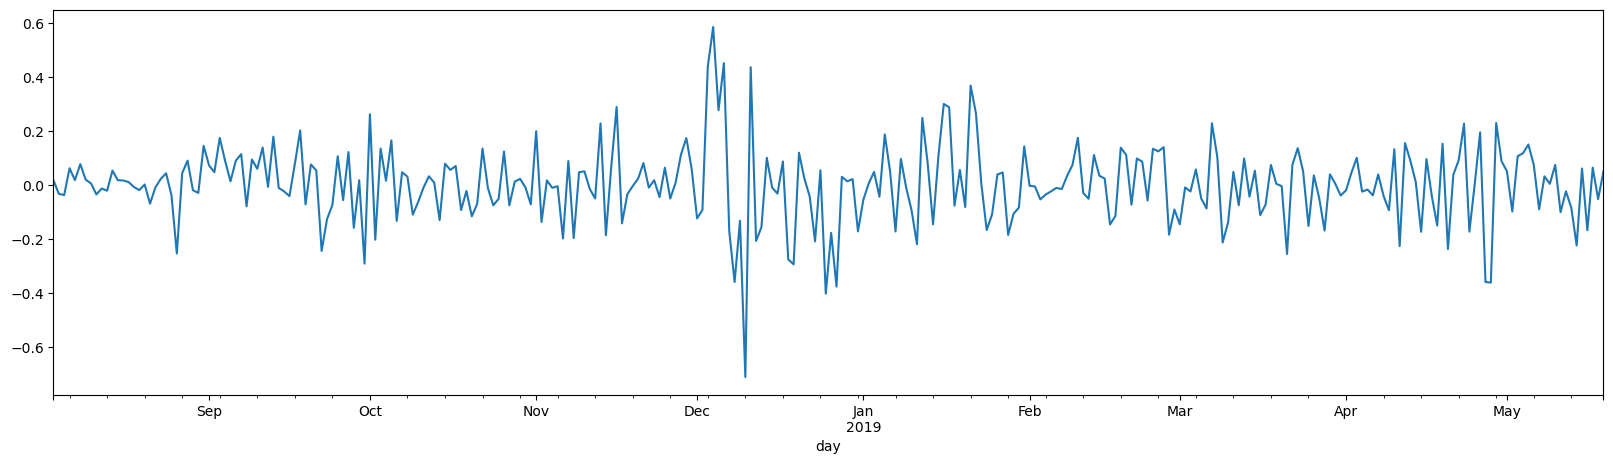

In [ ]:
residual_uuid = results_ret_armax.resid
residual_uuid[1:].plot(figsize=(20,5))
plt.title("")
plt.show()

#### Check the stationarity of residuals for have a good prediction: ADF-Test


In [ ]:
res = adfuller(residual_uuid)

#results:
adf_statistic = res[0]
p_value = res[1]
used_lag = res[2]
n_obs = res[3]
critical_values = res[4]
icbest = res[5]

print('Test di Dickey-Fuller aumentato (ADF)')
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Lags Used:', used_lag)
print('Number of Observations Used:', n_obs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

if p_value < 0.05:
    print("The time series is stationary (we reject the null hypothesis)")
else:
    print("The time series is not stationary (we do not reject the null hypothesis)")



Test di Dickey-Fuller aumentato (ADF)
ADF Statistic: -16.929543400874454
p-value: 9.800774738695771e-30
Lags Used: 0
Number of Observations Used: 290
Critical Values:
   1%: -3.453102162983312
   5%: -2.871558538275452
   10%: -2.5721082282996433
The time series is stationary (we reject the null hypothesis)


### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#### Check the mean of residuals, ideally near to zero

In [ ]:
mean_residual = np.mean(residual_uuid)
print("Mean residual:", mean_residual)

Mean residual: 0.0003846324764484167


#### Check the the autocorrelaton

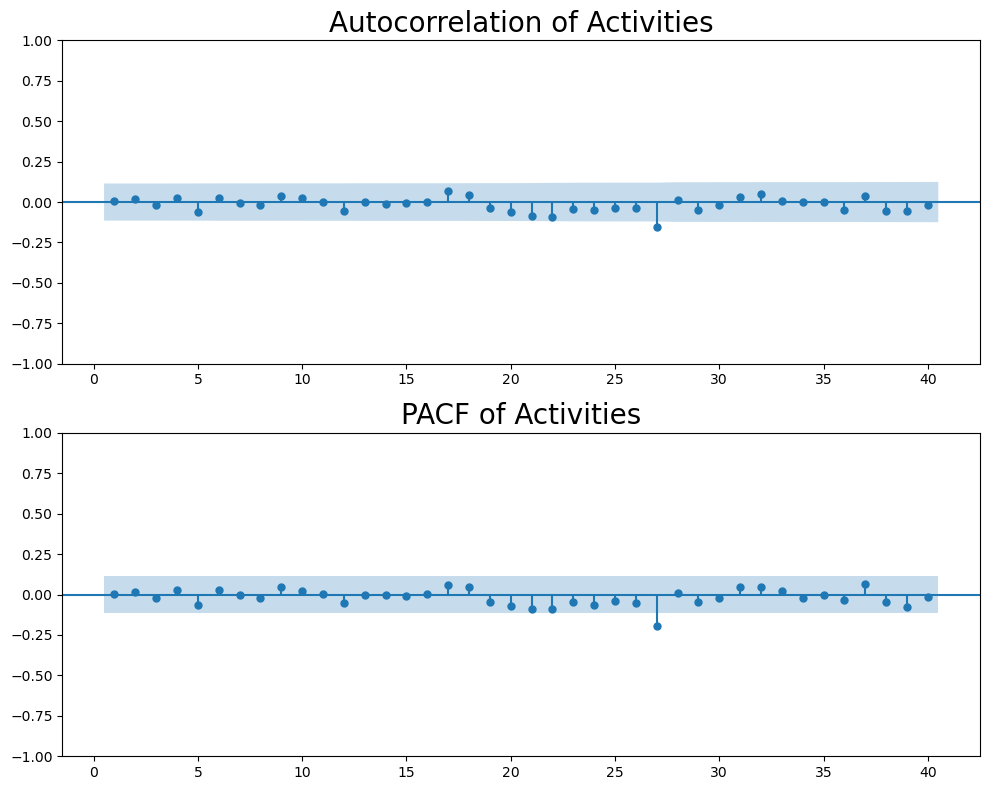

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
sgt.plot_acf(residual_uuid, lags=40, zero=False, ax=axes[0], title="Autocorrelation of Market Value")
axes[0].set_title("Autocorrelation of Activities", size=20)

# Plot PACF
sgt.plot_pacf(residual_uuid, lags=40, zero=False, method='ols', ax=axes[1])
axes[1].set_title("PACF of Activities", size=20)

# Display the plots
plt.tight_layout()
plt.show()

#### Check the Normality Distribution

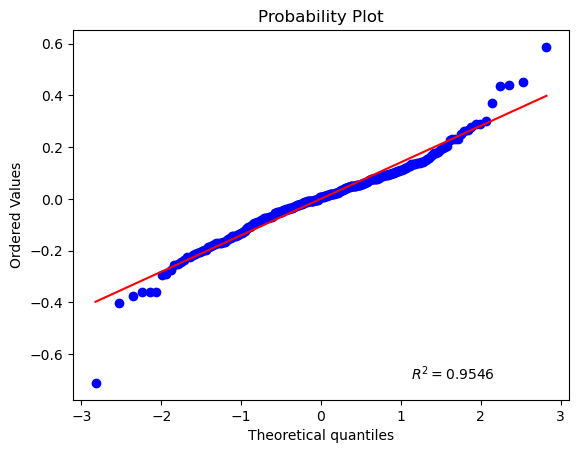

In [ ]:
scipy.stats.probplot(residual_uuid, plot= plt , fit = True, rvalue = True )

plt.show()

#### END :)